In [22]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [23]:
import os 
os.chdir('/kaggle/input/diffdata')

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.

        Parameters:
        - hr_images (list of ndarray): High-resolution images.
        - lr_images (list of ndarray): Low-resolution images.
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Ensure LR and HR images are 4D (N, C, H, W) for interpolation
        if len(lr.shape) == 2:  # If single channel 2D image
            lr = lr.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            hr = hr.unsqueeze(0).unsqueeze(0)
        elif len(lr.shape) == 3:  # If 3D (C, H, W) image
            lr = lr.unsqueeze(0)
            hr = hr.unsqueeze(0)
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr.squeeze(0)

In [29]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [30]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_dataloader)

In [34]:
import torch.optim as optim
from tqdm import tqdm

def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)   
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [35]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super(SinusoidalPositionEmbeddings, self).__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))

class ResBlock(nn.Module):
    def __init__(self, channels, time_dim):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x, t):
        time_emb = self.time_mlp(t).view(t.size(0), -1, 1, 1)
        identity = x
        out = self.leaky_relu(self.bn1(self.conv1(x)))
        out = out + time_emb
        out = self.leaky_relu(self.bn2(self.conv2(out)))
        out = out + identity
        return out

class Downsample(nn.Module):
    def __init__(self, in_channels, channels):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class ContractingStep(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(ContractingStep, self).__init__()
        self.res_block1 = ResBlock(in_channels, time_dim)
        self.res_block2 = ResBlock(in_channels, time_dim)
        self.downsample = Downsample(in_channels, out_channels)

    def forward(self, x, t_e):
        x = self.res_block1(x, t_e)
        x = self.res_block2(x, t_e)
        x = self.downsample(x)
        return x

class ExpansiveStep(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(ExpansiveStep, self).__init__()
        self.res_block1 = ResBlock(in_channels, time_dim)
        self.res_block2 = ResBlock(in_channels, time_dim)
        self.upsample = Upsample(in_channels, out_channels)

    def forward(self, x, t):
        x = self.res_block1(x, t)
        x = self.res_block2(x, t)
        x = self.upsample(x)
        return x

class MiddleStep(nn.Module):
    def __init__(self, channels, time_dim):
        super(MiddleStep, self).__init__()
        self.res_block1 = ResBlock(channels, time_dim)
        self.res_block2 = ResBlock(channels, time_dim)

    def forward(self, x, t):
        x = self.res_block1(x, t)
        x = self.res_block2(x, t)
        return x

class SRDiff(nn.Module):
    def __init__(self, c):
        super(SRDiff, self).__init__()
        self.lr_encoder = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU()
        )
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        
        self.conv_block_initial = ConvBlock(1, c)
        self.contracting_step1 = ContractingStep(c, c, c)
        self.contracting_step2 = ContractingStep(c, 2 * c, c)
        self.contracting_step3 = ContractingStep(2 * c, 2 * c, c)
        self.contracting_step4 = ContractingStep(2 * c, 4 * c, c)
        
        self.middle_step = MiddleStep(4 * c, c)
        
        self.expansive_step1 = ExpansiveStep(4 * c, 4 * c, c)
        self.expansive_step2 = ExpansiveStep(4 * c, 2 * c, c)
        self.expansive_step3 = ExpansiveStep(2 * c, 2 * c, c)
        self.expansive_step4 = ExpansiveStep(2 * c, c, c)
        
        self.final_conv_block = nn.Sequential(
            ConvBlock(c, c),
            nn.Conv2d(c, 1, kernel_size=1)
        )
        
    def forward(self, x_t, x_L, timesteps):
        x_e = self.lr_encoder(x_L)
        t_e = self.time_mlp(timesteps.float())

        x_t = self.conv_block_initial(x_t)
        x_t = x_t + x_e
        x = self.contracting_step1(x_t, t_e)
        x = self.contracting_step2(x, t_e)
        x = self.contracting_step3(x, t_e)
        x = self.contracting_step4(x, t_e)
        
        # Middle step
        x = self.middle_step(x, t_e)
        
        # Expansive steps
        x = self.expansive_step1(x, t_e)
        x = self.expansive_step2(x, t_e)
        x = self.expansive_step3(x, t_e)
        x = self.expansive_step4(x, t_e)
        
        x = self.final_conv_block(x)
        
        return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using device: {device}, Number of GPUs: {num_gpus}")

model = SRDiff(c=64) 

if num_gpus > 1:
    model = nn.DataParallel(model)
model.to(device)

Using device: cuda, Number of GPUs: 2


DataParallel(
  (module): SRDiff(
    (lr_encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv_block_initial): ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (contracting_step1): ContractingStep(
      (res_block1): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1

In [38]:
model_path = '/kaggle/working/SRDiff.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Epoch 1/20: 100%|██████████| 638/638 [01:10<00:00,  9.04batch/s, loss=0.0374] 


End of Epoch 1 | Avg Loss: 0.01027409


Epoch 2/20: 100%|██████████| 638/638 [01:10<00:00,  9.06batch/s, loss=0.00386]


End of Epoch 2 | Avg Loss: 0.01024163


Epoch 3/20: 100%|██████████| 638/638 [01:10<00:00,  9.07batch/s, loss=0.00843]


End of Epoch 3 | Avg Loss: 0.01024946


Epoch 4/20: 100%|██████████| 638/638 [01:09<00:00,  9.12batch/s, loss=0.00684]


End of Epoch 4 | Avg Loss: 0.01024207


Epoch 5/20: 100%|██████████| 638/638 [01:10<00:00,  9.03batch/s, loss=0.015]  


End of Epoch 5 | Avg Loss: 0.01026293


Epoch 6/20: 100%|██████████| 638/638 [01:09<00:00,  9.19batch/s, loss=0.0055] 


End of Epoch 6 | Avg Loss: 0.01025613


Epoch 7/20: 100%|██████████| 638/638 [01:08<00:00,  9.26batch/s, loss=0.0159] 


End of Epoch 7 | Avg Loss: 0.01026347


Epoch 8/20: 100%|██████████| 638/638 [01:09<00:00,  9.21batch/s, loss=0.0237] 


End of Epoch 8 | Avg Loss: 0.01025953


Epoch 9/20: 100%|██████████| 638/638 [01:09<00:00,  9.17batch/s, loss=0.0119] 


End of Epoch 9 | Avg Loss: 0.01025600


Epoch 10/20: 100%|██████████| 638/638 [01:09<00:00,  9.20batch/s, loss=0.00712]


End of Epoch 10 | Avg Loss: 0.01028125


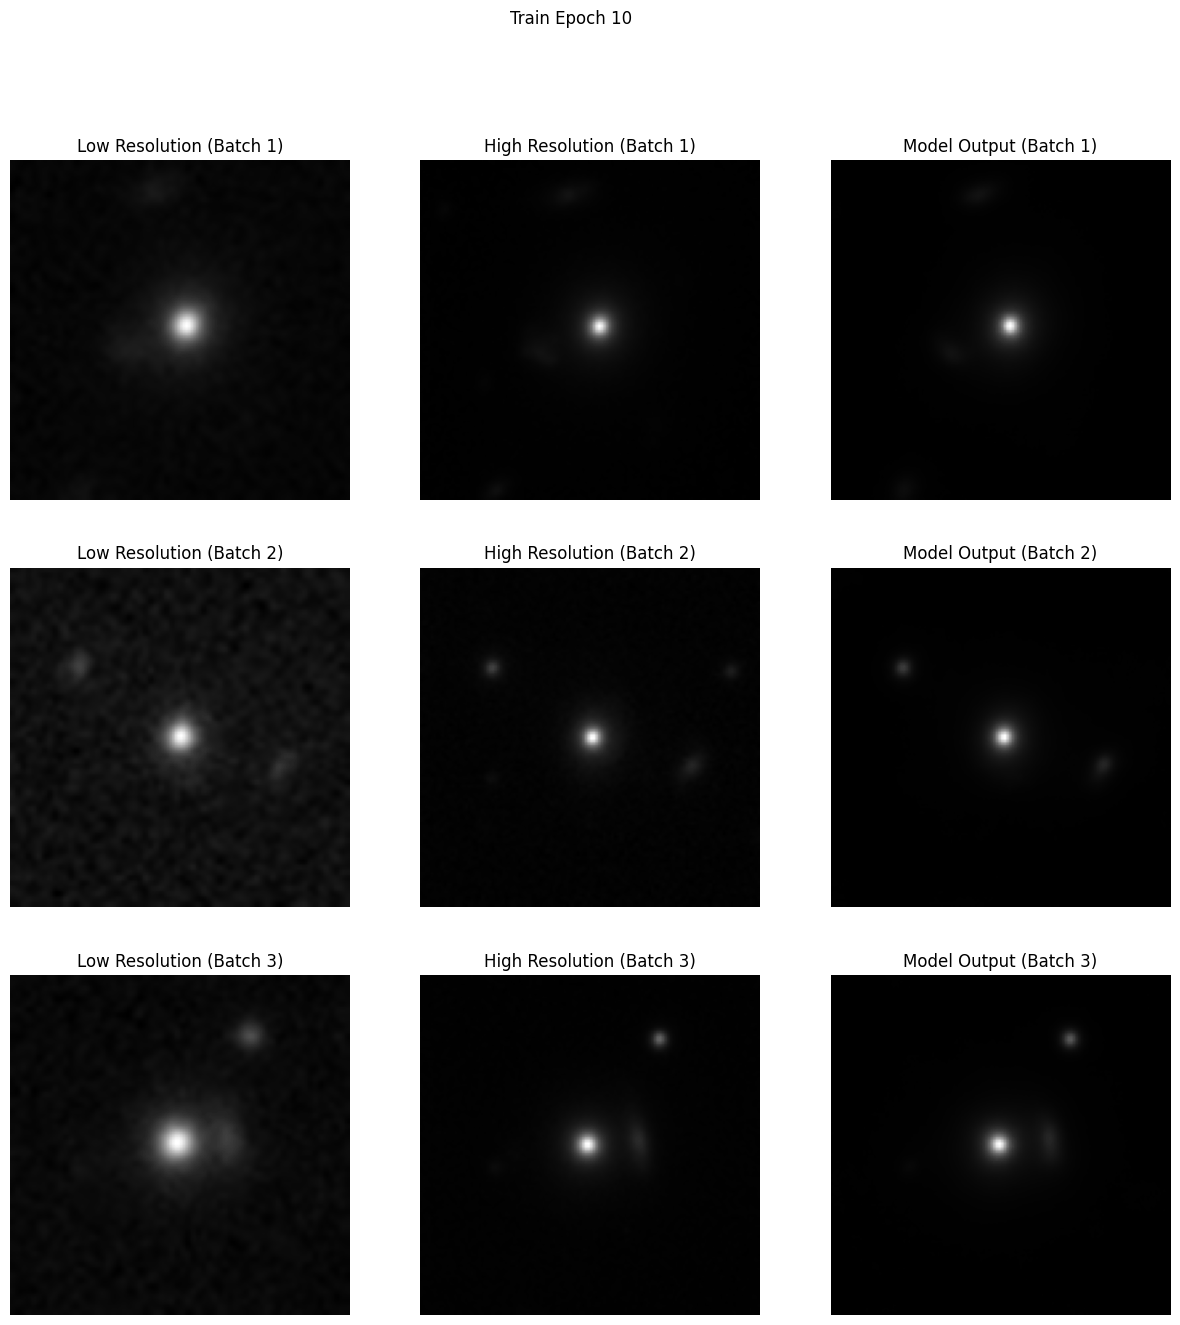

Epoch 11/20: 100%|██████████| 638/638 [01:09<00:00,  9.15batch/s, loss=0.00743]


End of Epoch 11 | Avg Loss: 0.01024246


Epoch 12/20: 100%|██████████| 638/638 [01:09<00:00,  9.14batch/s, loss=0.0166] 


End of Epoch 12 | Avg Loss: 0.01025384


Epoch 13/20: 100%|██████████| 638/638 [01:10<00:00,  9.05batch/s, loss=0.00966]


End of Epoch 13 | Avg Loss: 0.01024268


Epoch 14/20: 100%|██████████| 638/638 [01:09<00:00,  9.12batch/s, loss=0.00637]


End of Epoch 14 | Avg Loss: 0.01023850


Epoch 15/20:  37%|███▋      | 235/638 [00:25<00:42,  9.41batch/s, loss=0.00468]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Helper functions
def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

def plot_images(lr_images, hr_images, model_images, epoch, phase='Train'):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        axes[i, 0].imshow(lr_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 0].set_title(f'Low Resolution (Batch {i+1})')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(hr_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title(f'High Resolution (Batch {i+1})')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(model_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title(f'Model Output (Batch {i+1})')
        axes[i, 2].axis('off')
    plt.suptitle(f'{phase} Epoch {epoch}')
    plt.show()

# Define the optimizer and parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
epochs = 20

# Diffusion process parameters
T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
        for step, (lr, hr) in enumerate(train_dataloader):
            lr, hr = lr.to(device), hr.to(device)

            optimizer.zero_grad()
            
            timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
            noisy_hr, noise = forward_diffusion_sample(hr, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
            
            predicted_hr = model(noisy_hr, lr, timesteps)
            loss = nn.L1Loss()(predicted_hr, hr)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
    
    epoch_loss /= len(train_dataloader)
    print(f"End of Epoch {epoch+1} | Avg Loss: {epoch_loss:.8f}")

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            for step, (lr, hr) in enumerate(train_dataloader):
                if step >= 3:  # Only plot for the first three batches
                    break
                lr, hr = lr.to(device), hr.to(device)
                timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
                noisy_hr, _ = forward_diffusion_sample(hr, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
                model_output = model(noisy_hr, lr, timesteps)
                plot_images(lr, hr, model_output, epoch + 1, phase='Train')
                break

print("Training complete.")


In [ ]:
torch.save(model.state_dict(), '/kaggle/working/SRDiff.pth')

In [39]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, win_size=11, data_range=1.0):
    model.eval()
    mse_lr_hr = 0.0
    mse_lr_predhr = 0.0
    mse_hr_predhr = 0.0
    psnr_lr_hr = 0.0
    psnr_lr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_lr_hr = 0.0
    ssim_lr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0

    with torch.no_grad():
        for step, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
            noisy_lr, _ = forward_diffusion_sample(lr, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
            predicted_hr = model(noisy_lr, lr, timesteps)

            # Loop over each image in the batch
            batch_size = lr.size(0)
            for i in range(batch_size):
                mse_lr_hr += nn.MSELoss()(lr[i], hr[i]).item()
                mse_lr_predhr += nn.MSELoss()(lr[i], predicted_hr[i]).item()
                mse_hr_predhr += nn.MSELoss()(hr[i], predicted_hr[i]).item()

                psnr_lr_hr += calculate_psnr(lr[i], hr[i])
                psnr_lr_predhr += calculate_psnr(lr[i], predicted_hr[i])
                psnr_hr_predhr += calculate_psnr(hr[i], predicted_hr[i])

                ssim_lr_hr += calculate_ssim(lr[i], hr[i], data_range, win_size)
                ssim_lr_predhr += calculate_ssim(lr[i], predicted_hr[i], data_range, win_size)
                ssim_hr_predhr += calculate_ssim(hr[i], predicted_hr[i], data_range, win_size)

                num_samples += 1

    mse_lr_hr /= num_samples
    mse_lr_predhr /= num_samples
    mse_hr_predhr /= num_samples
    psnr_lr_hr /= num_samples
    psnr_lr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_lr_hr /= num_samples
    ssim_lr_predhr /= num_samples
    ssim_hr_predhr /= num_samples

    print(f"Avg MSE (LR, HR): {mse_lr_hr:.8f}")
    print(f"Avg MSE (LR, Predicted HR): {mse_lr_predhr:.8f}")
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (LR, HR): {psnr_lr_hr:.8f}")
    print(f"Avg PSNR (LR, Predicted HR): {psnr_lr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (LR, HR): {ssim_lr_hr:.8f}")
    print(f"Avg SSIM (LR, Predicted HR): {ssim_lr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

# Helper functions
def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].to(device).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device).view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# Assuming that 'model', 'test_dataloader', 'sqrt_alphas_cumprod', and 'sqrt_one_minus_alphas_cumprod' are already defined
evaluate_model(model, test_dataloader, sqrt_alphas_cumprod.to(device), sqrt_one_minus_alphas_cumprod.to(device))


Avg MSE (LR, HR): 0.03888605
Avg MSE (LR, Predicted HR): 0.03753279
Avg MSE (HR, Predicted HR): 0.00072933
Avg PSNR (LR, HR): 16.92149353
Avg PSNR (LR, Predicted HR): 17.15979958
Avg PSNR (HR, Predicted HR): 34.71915054
Avg SSIM (LR, HR): 0.54648887
Avg SSIM (LR, Predicted HR): 0.56867277
Avg SSIM (HR, Predicted HR): 0.87088919


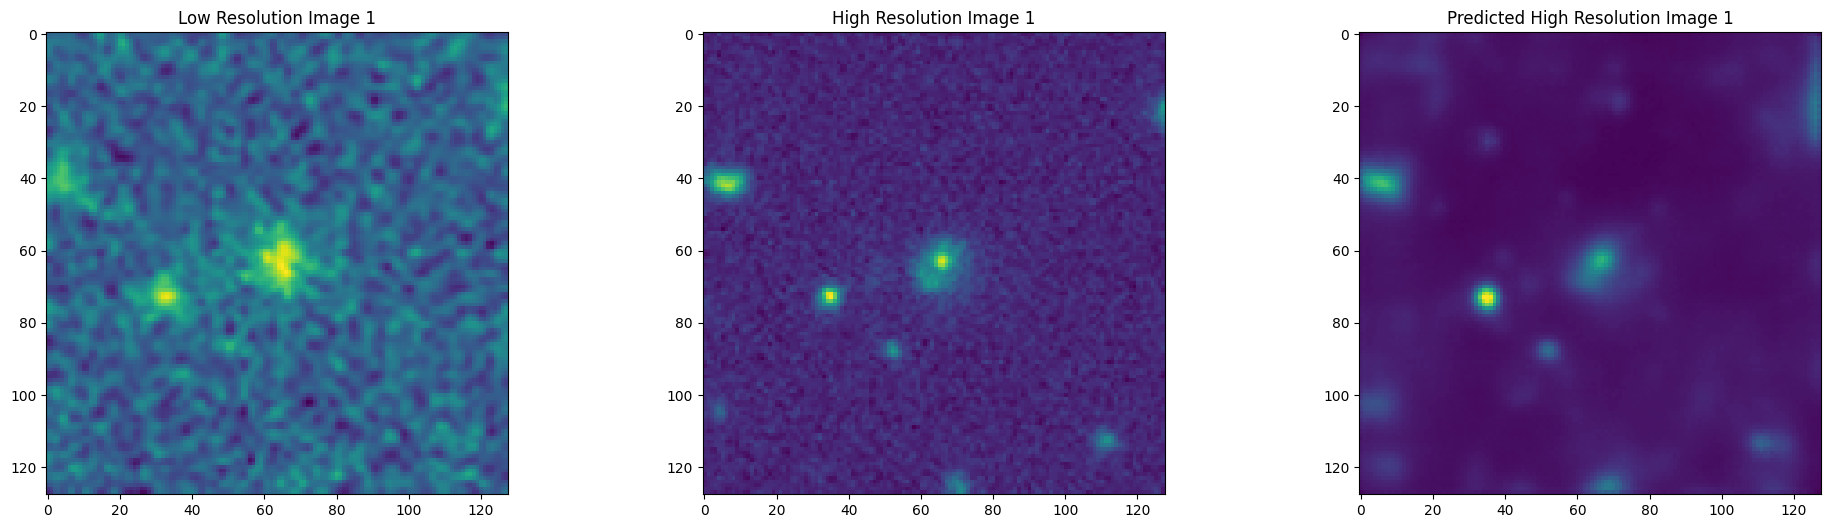

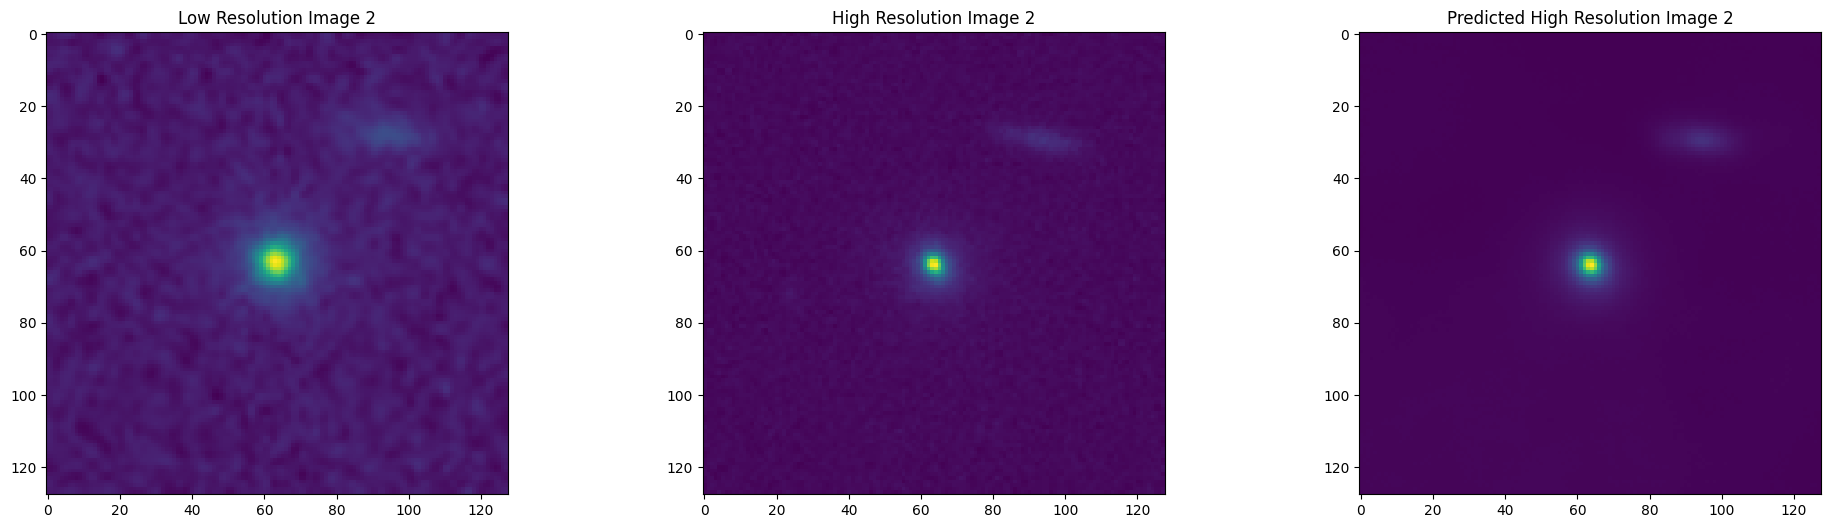

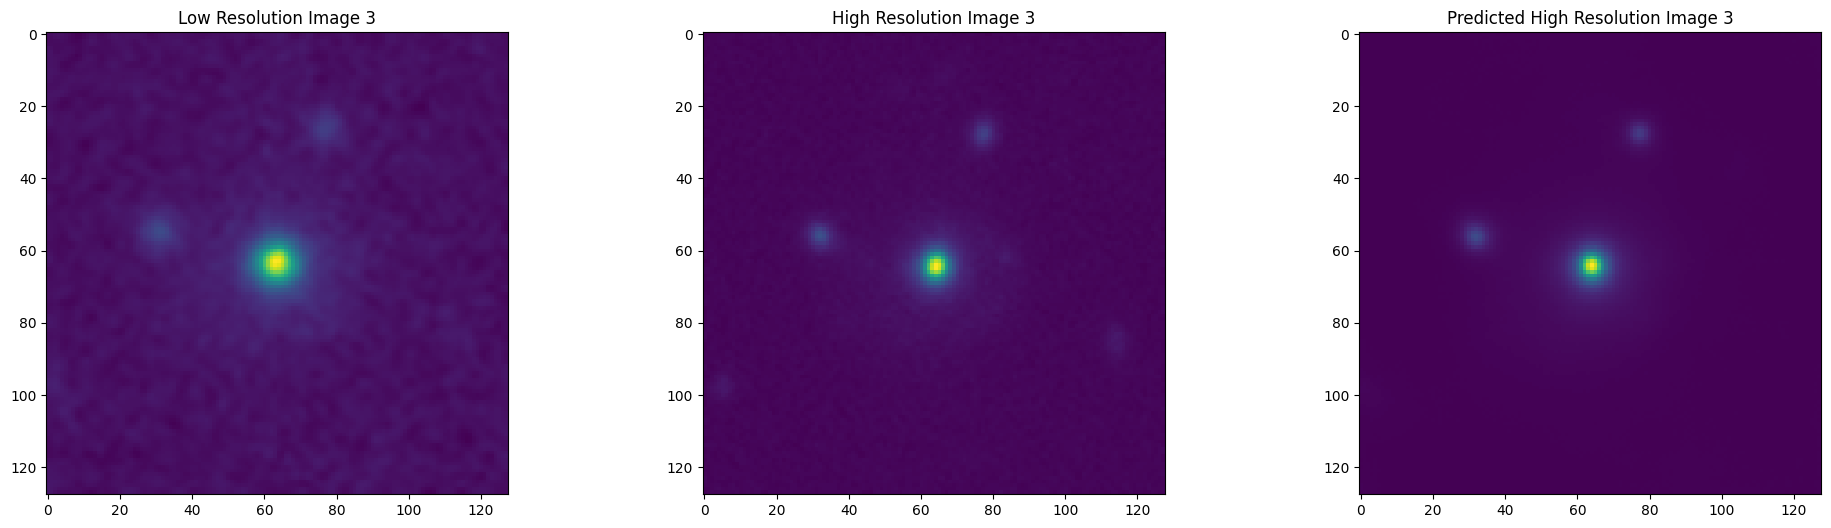

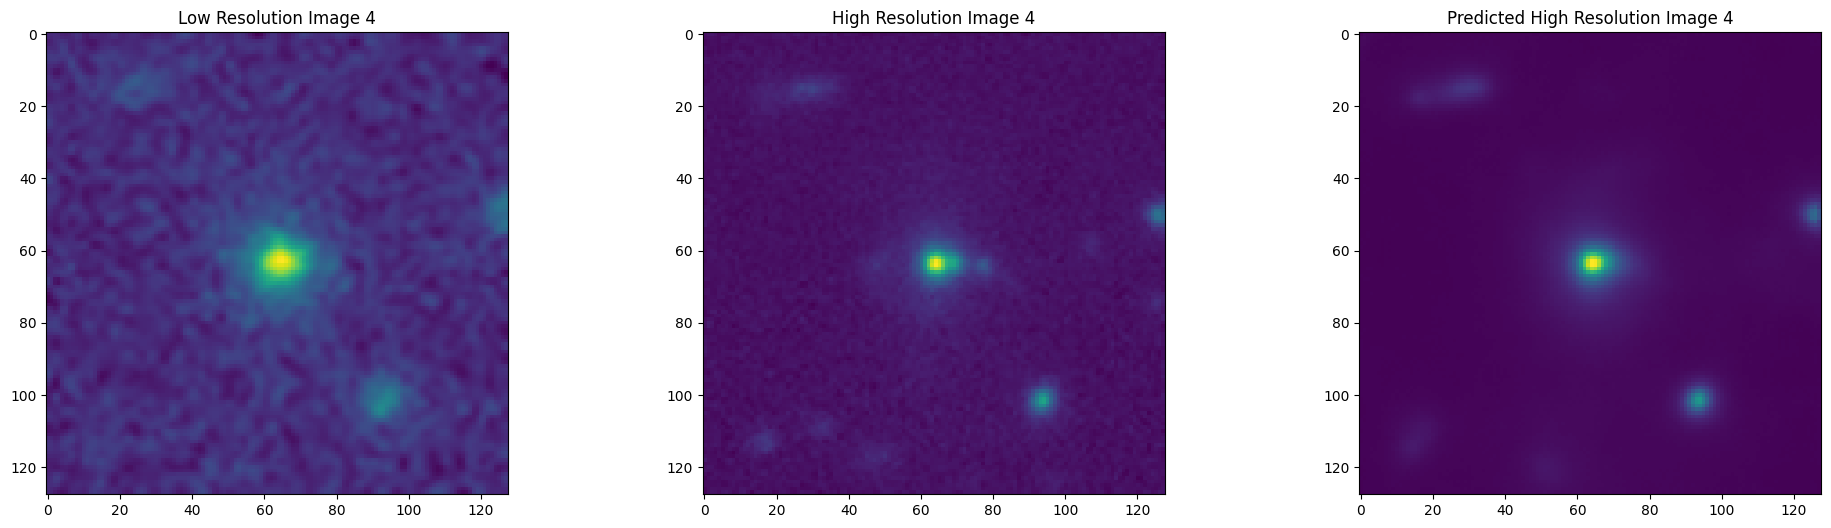

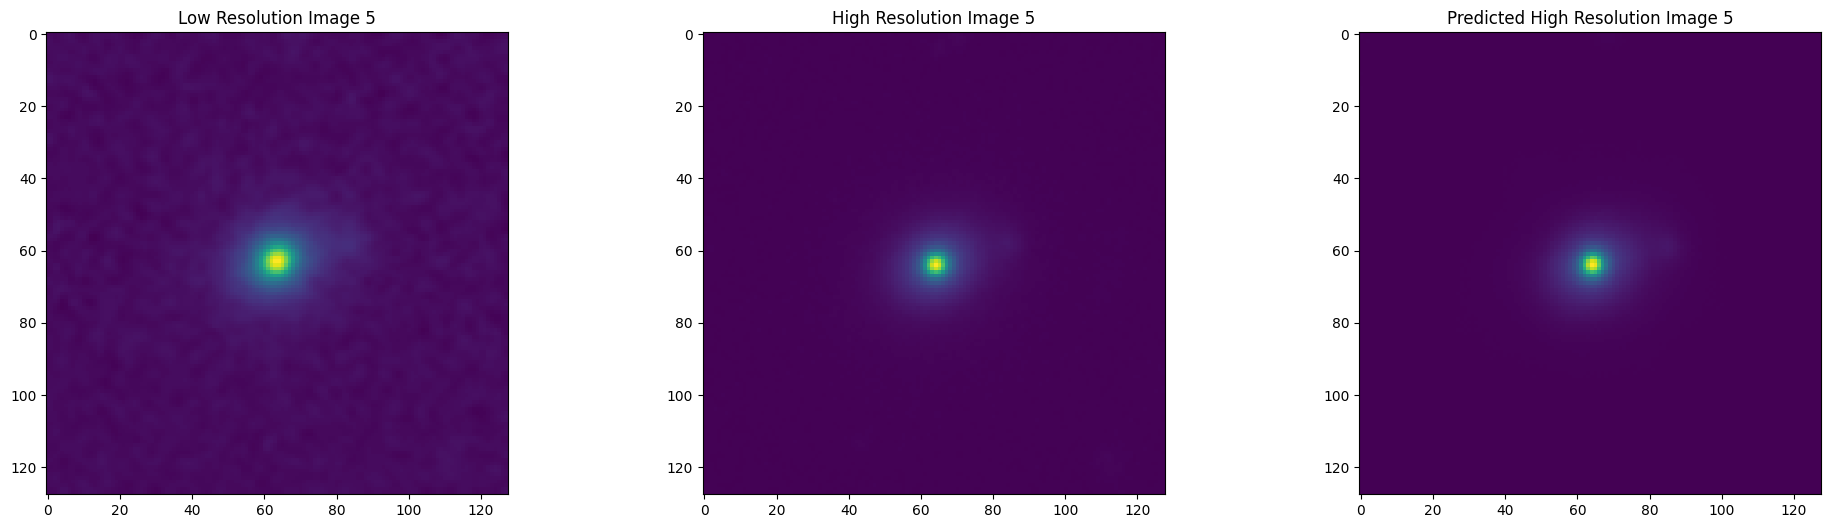

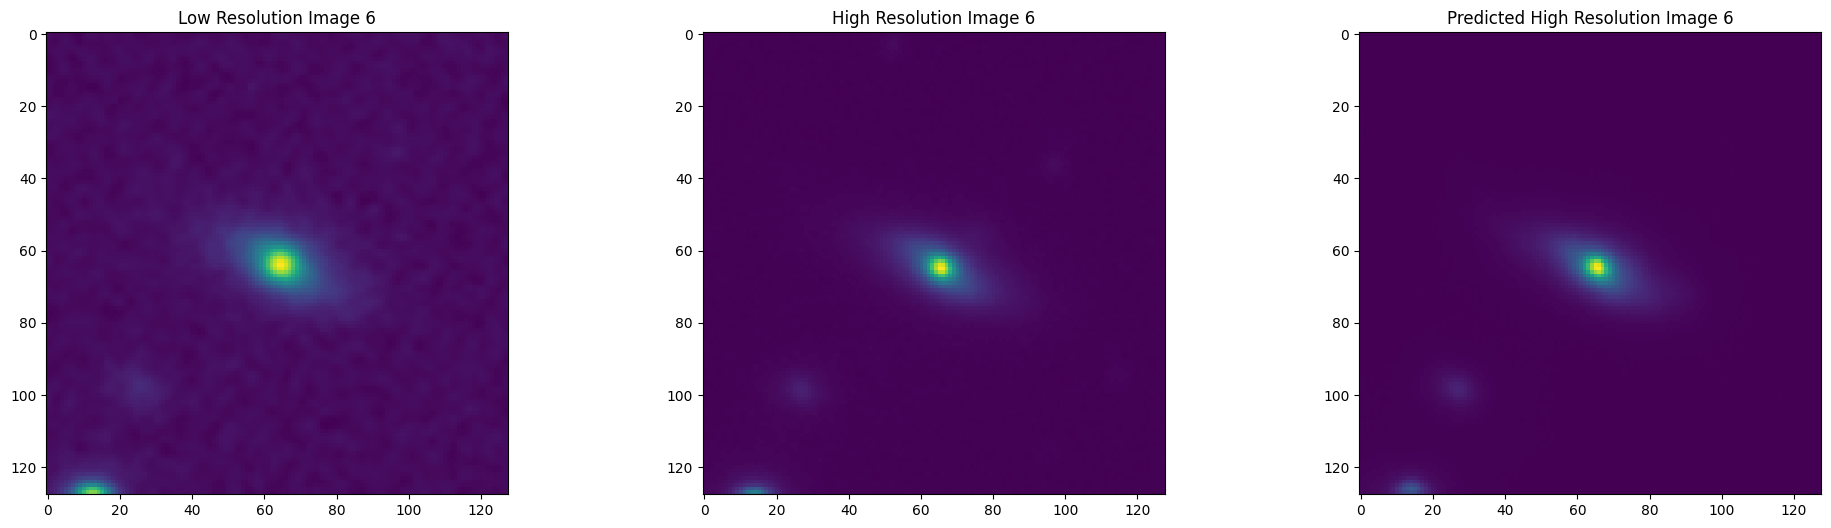

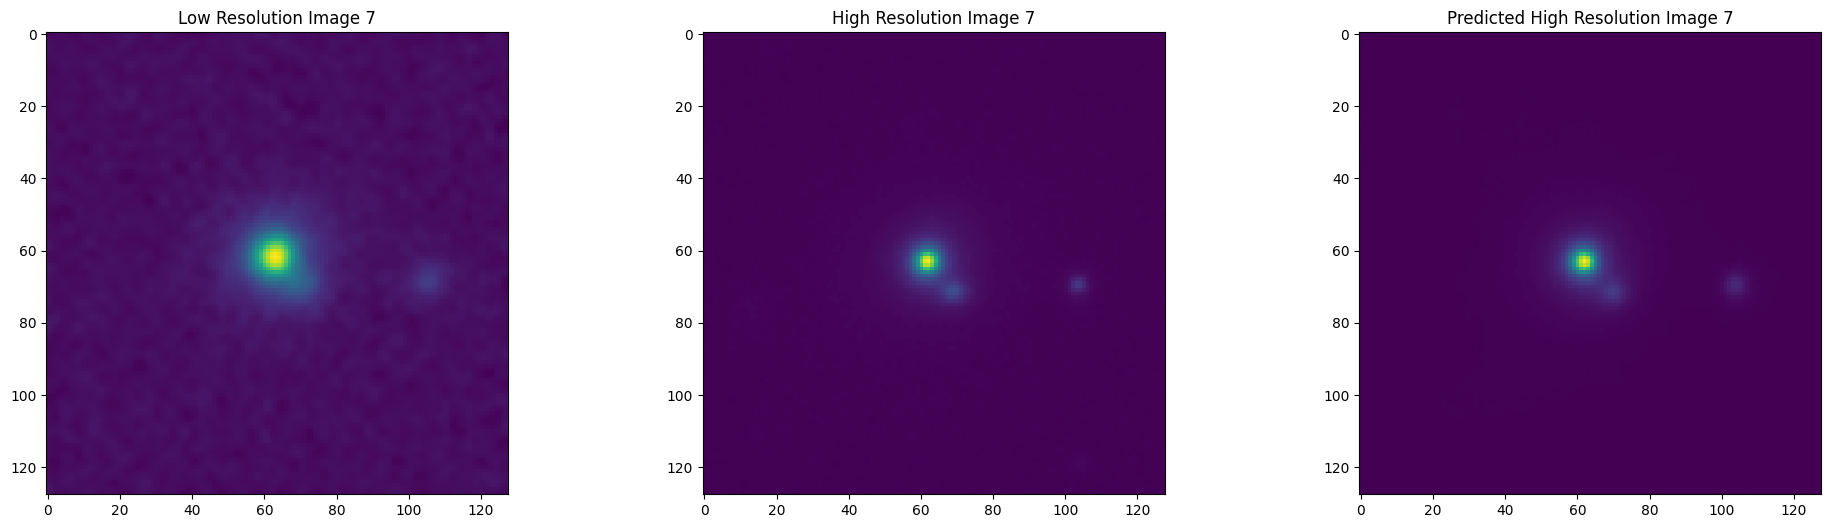

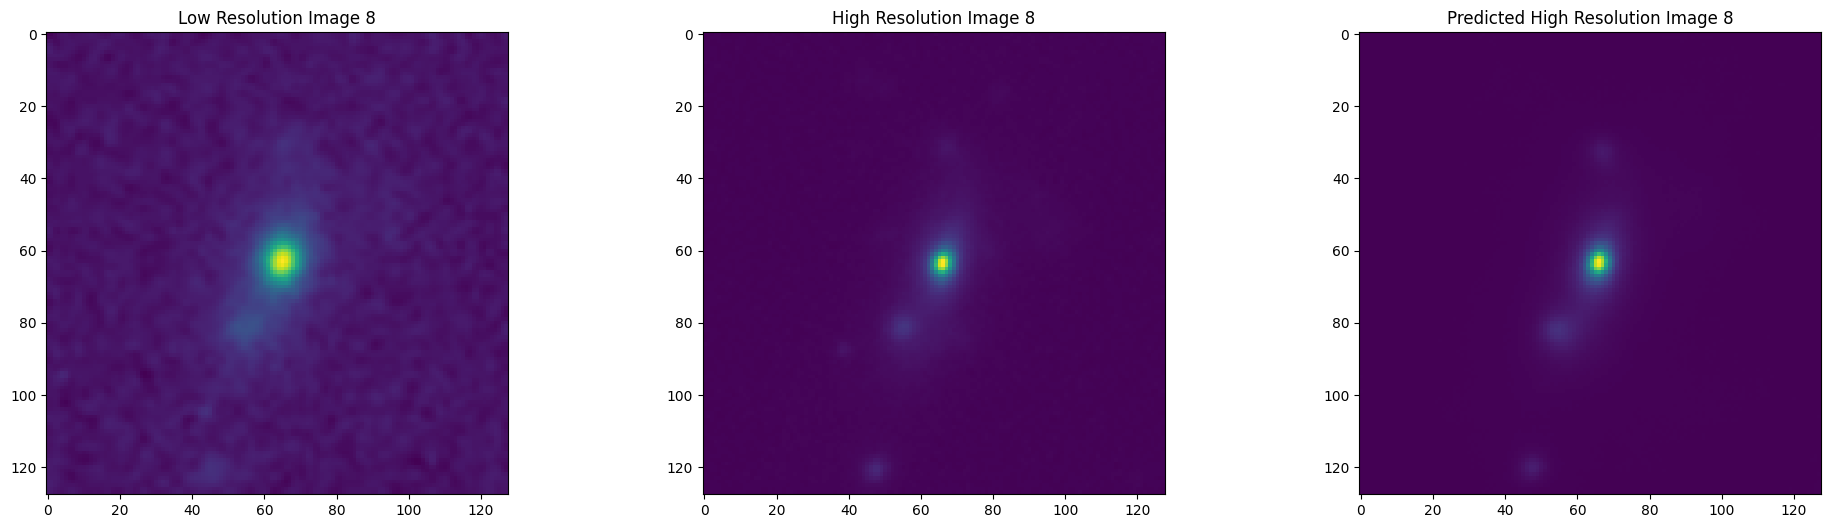

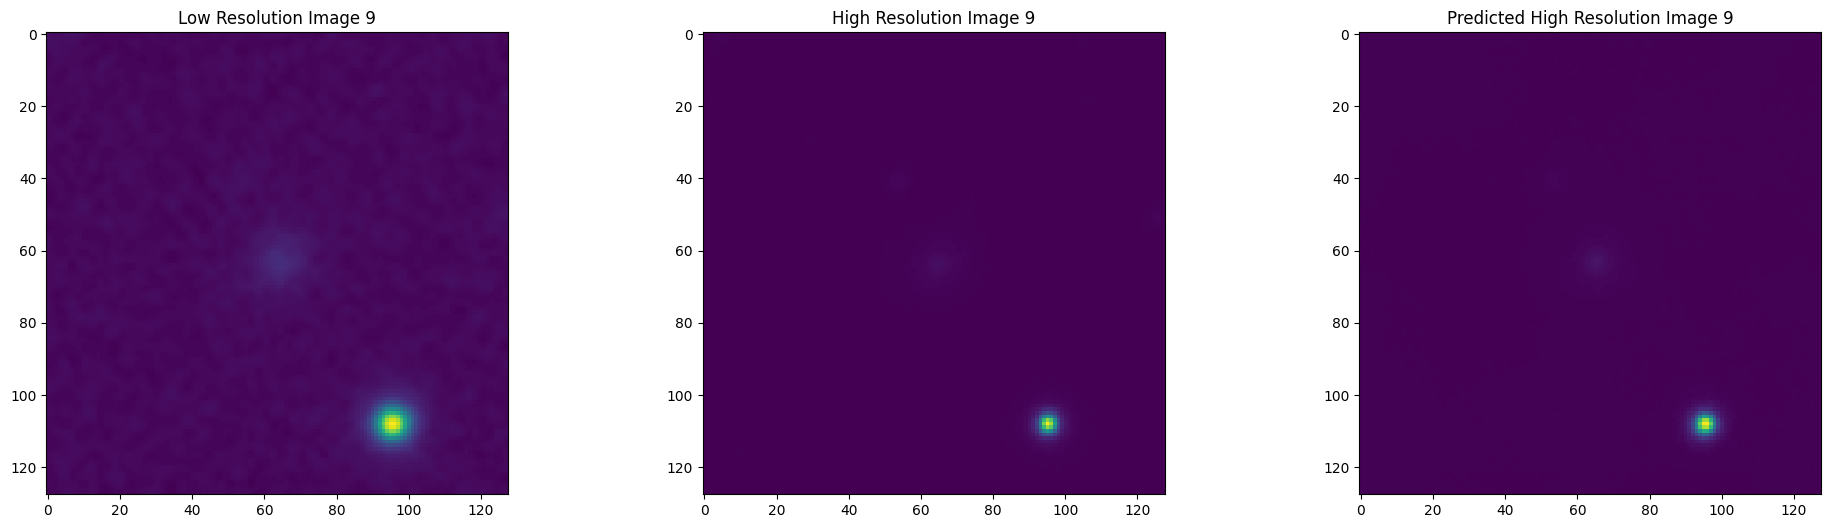

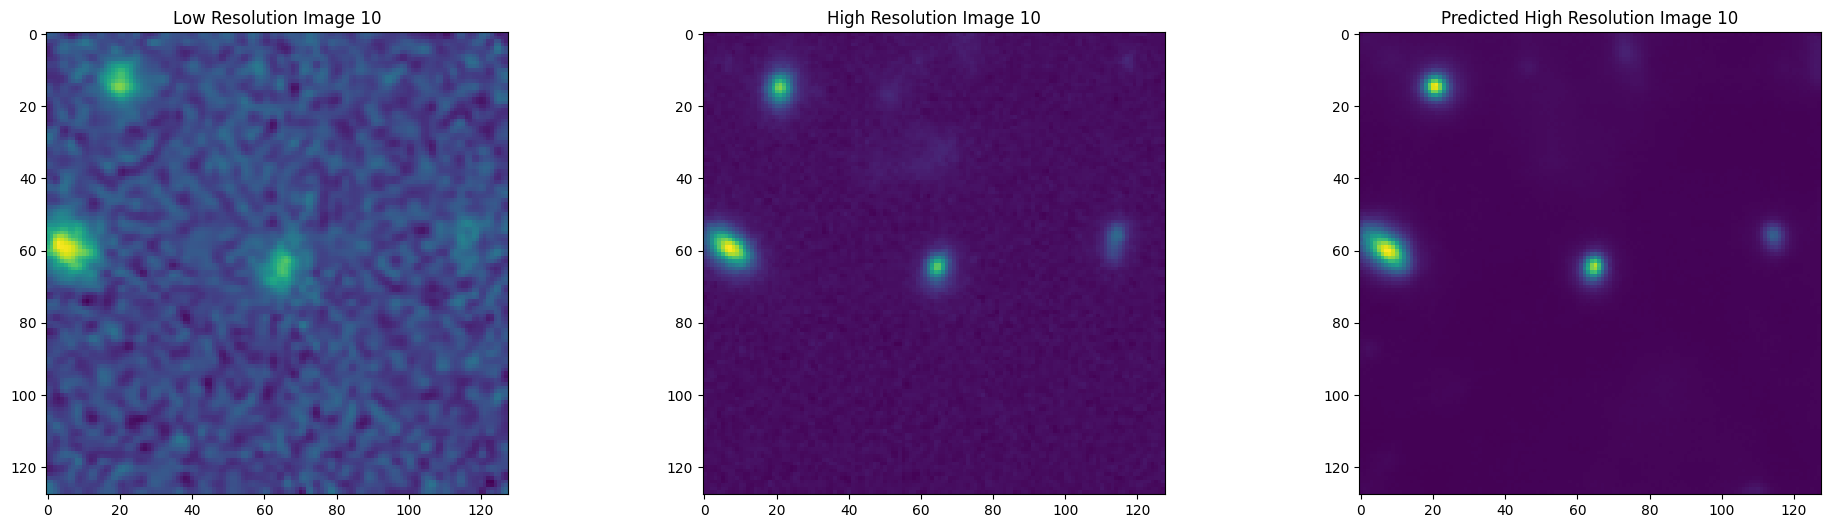

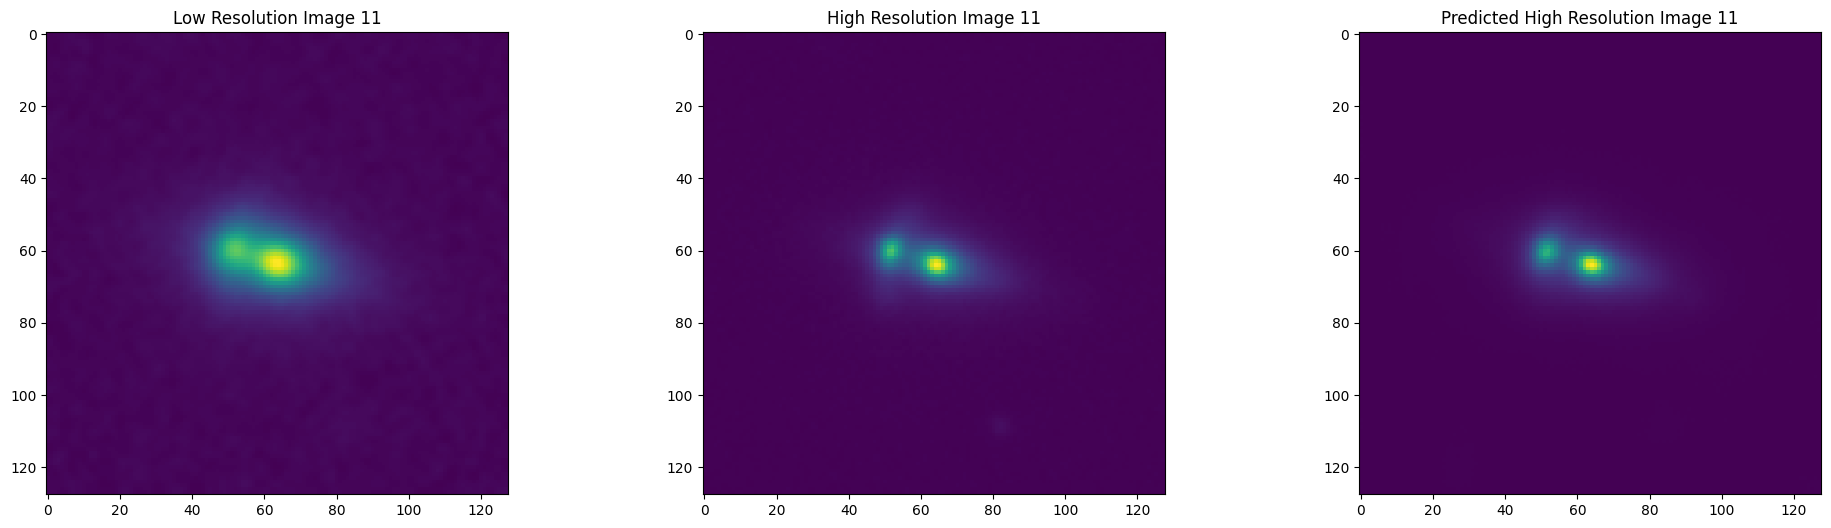

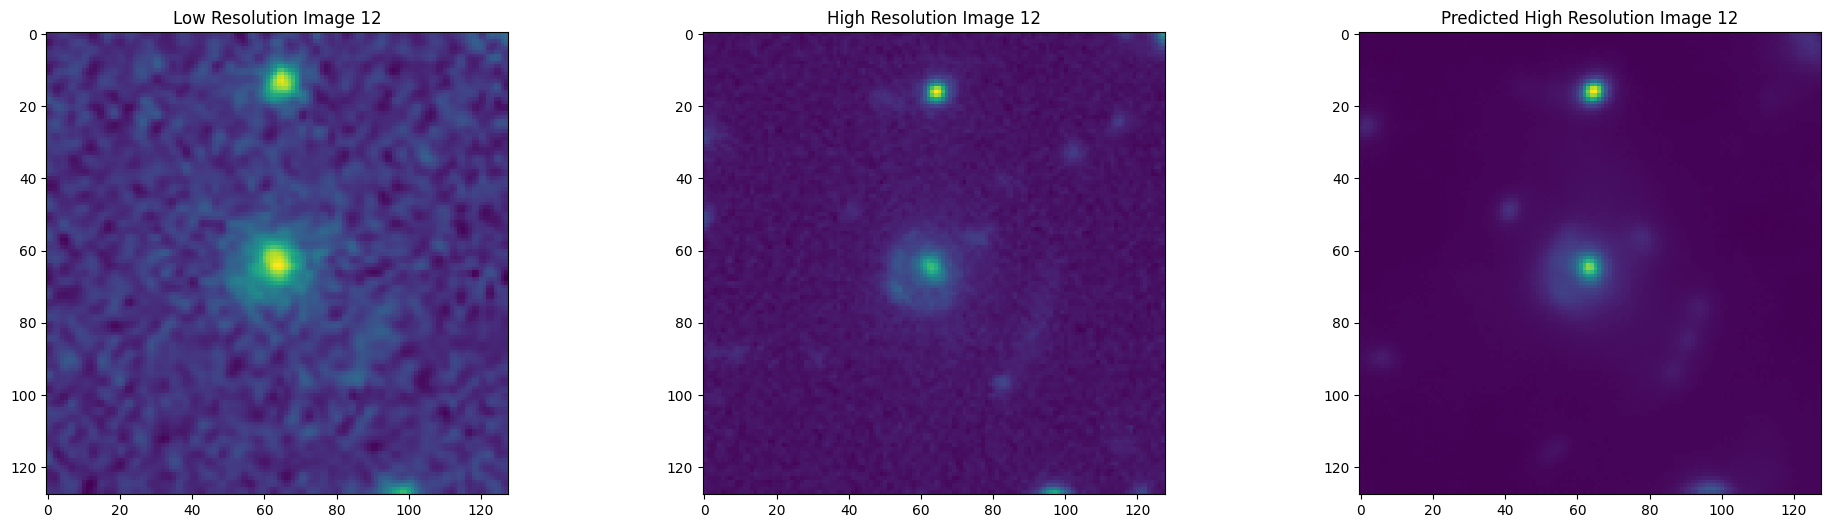

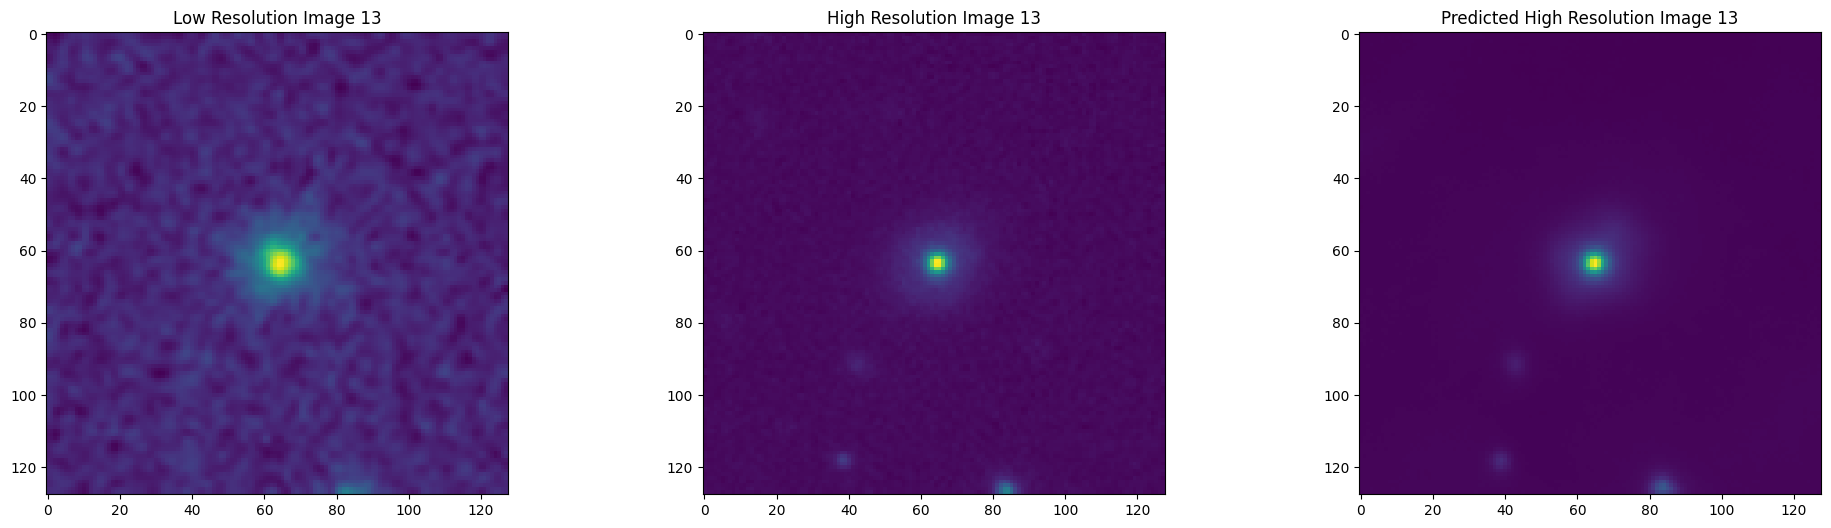

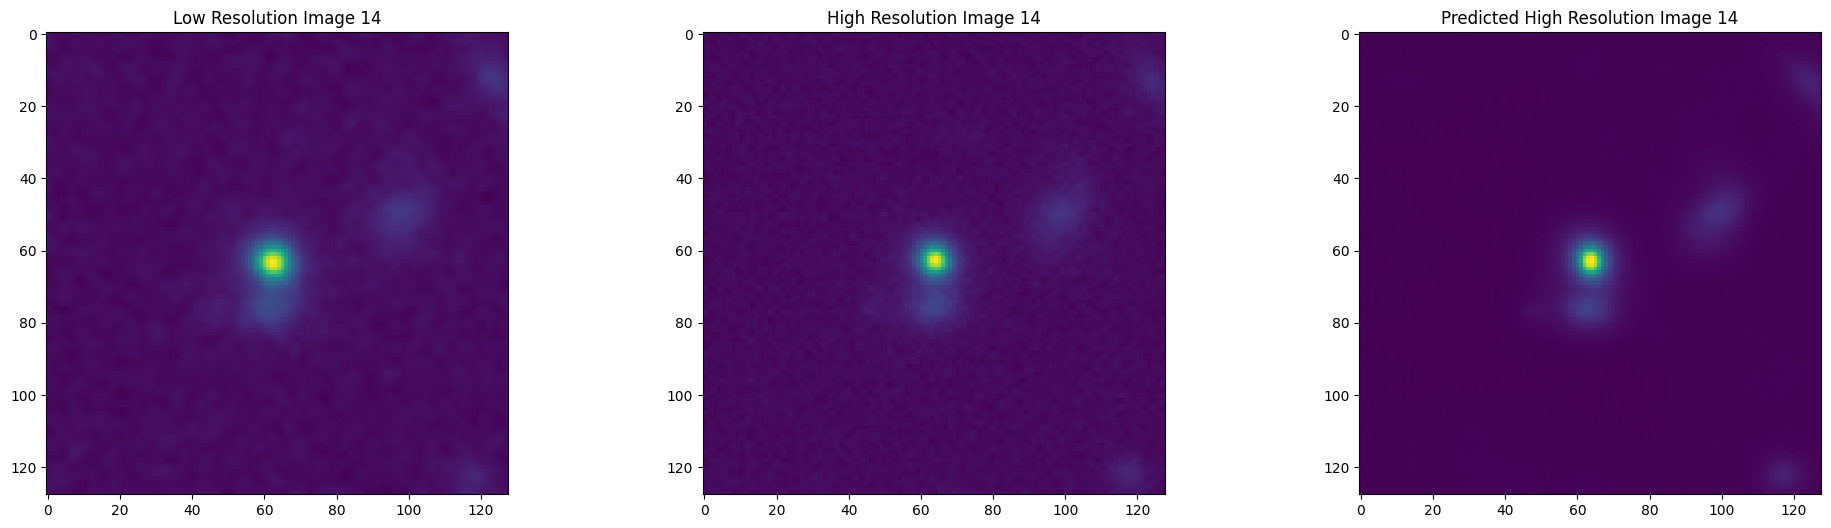

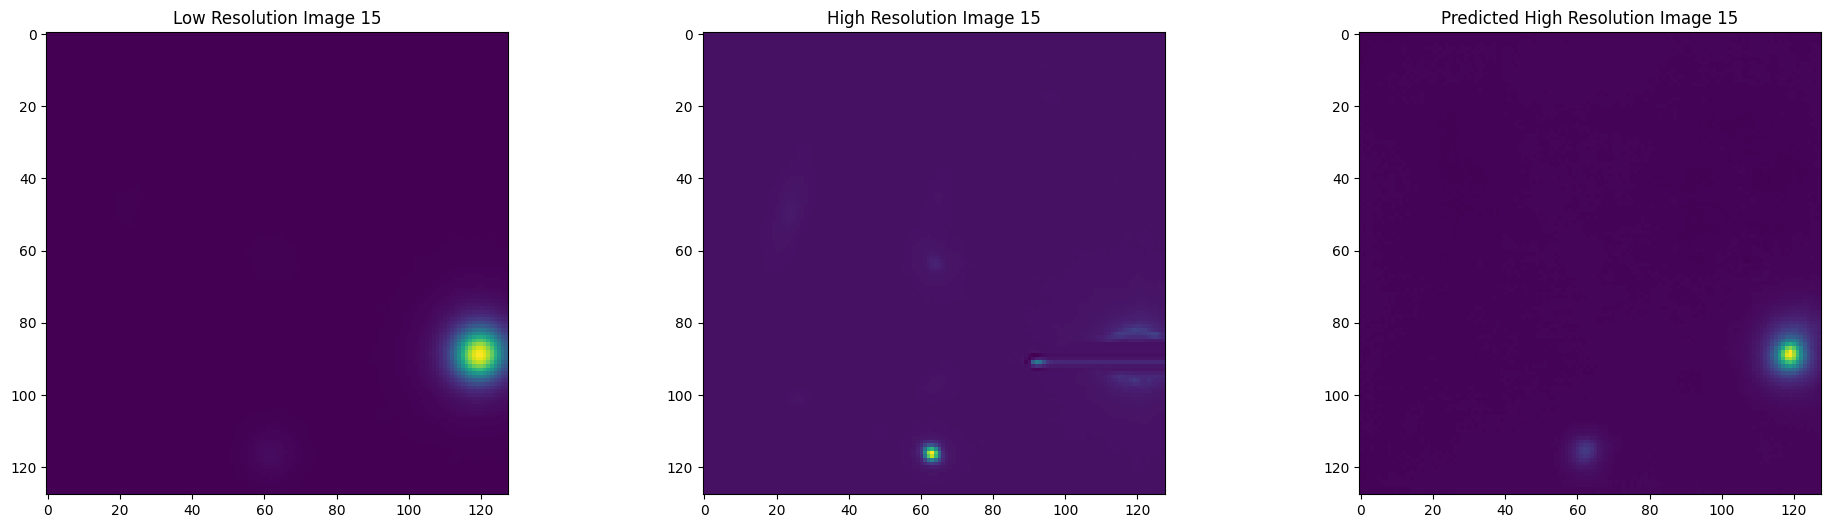

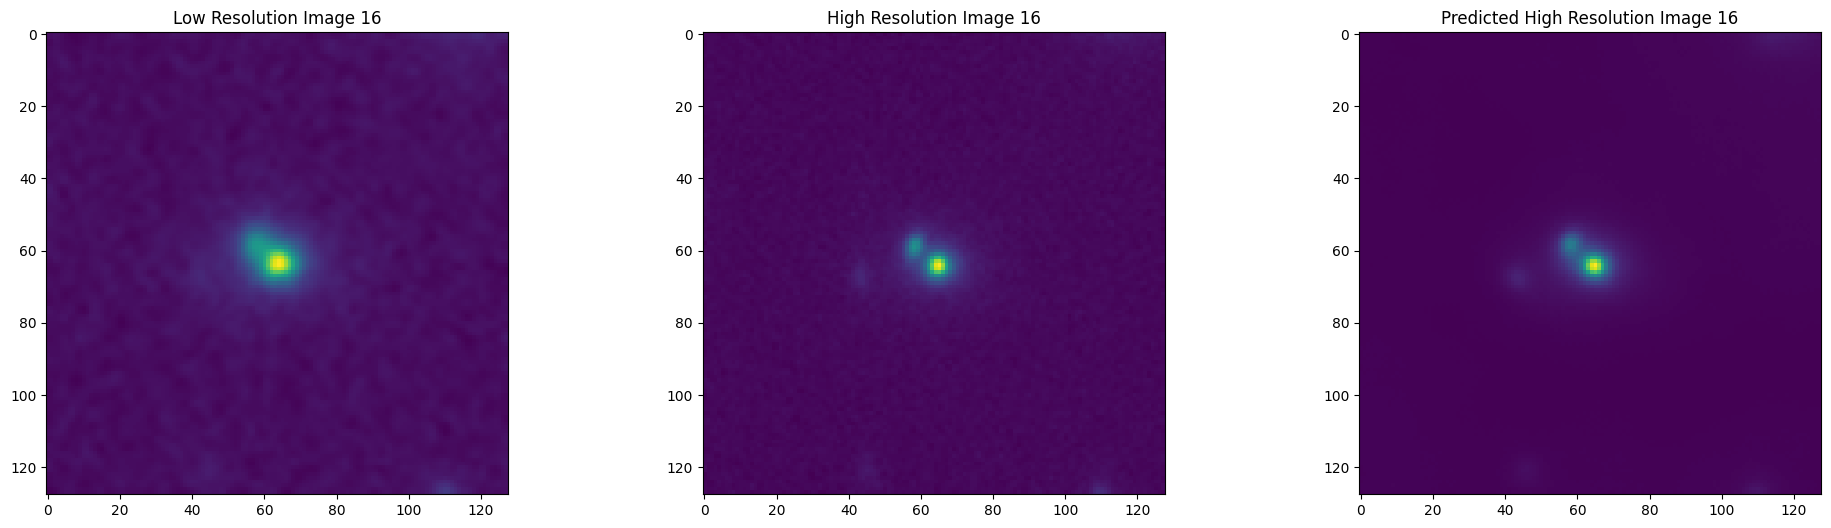

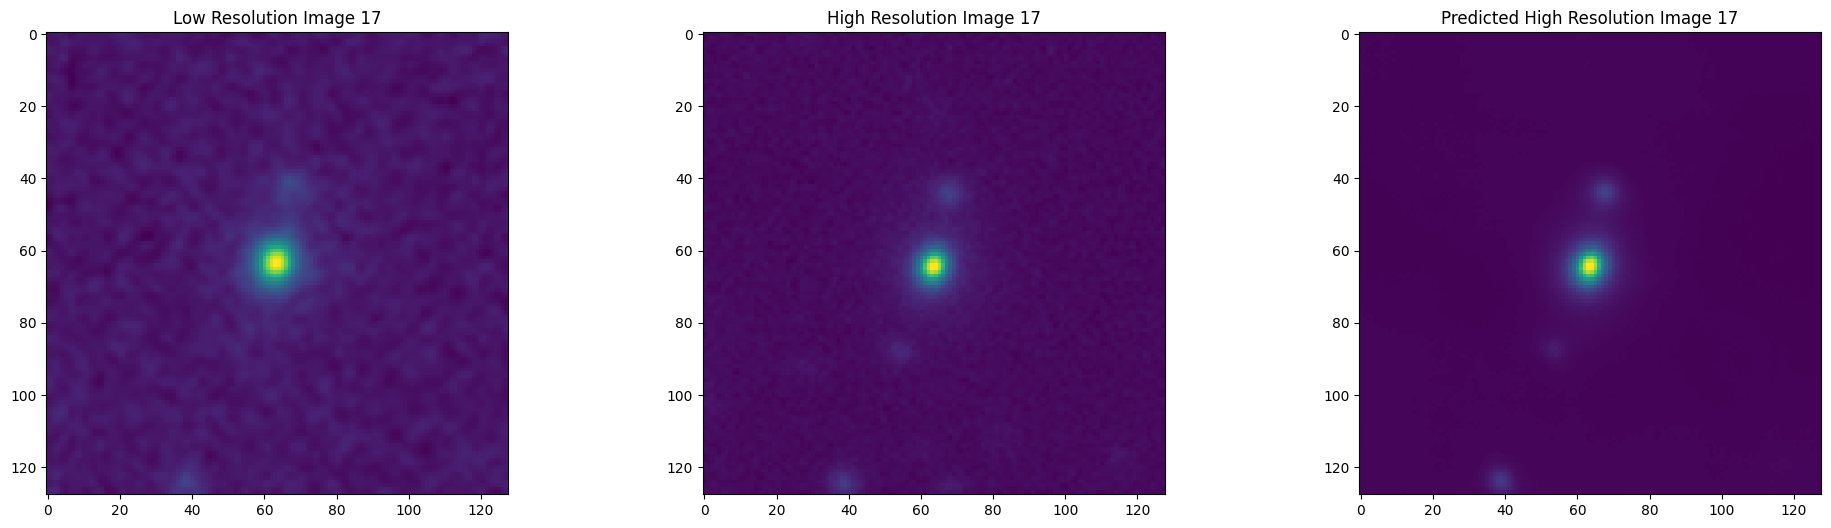

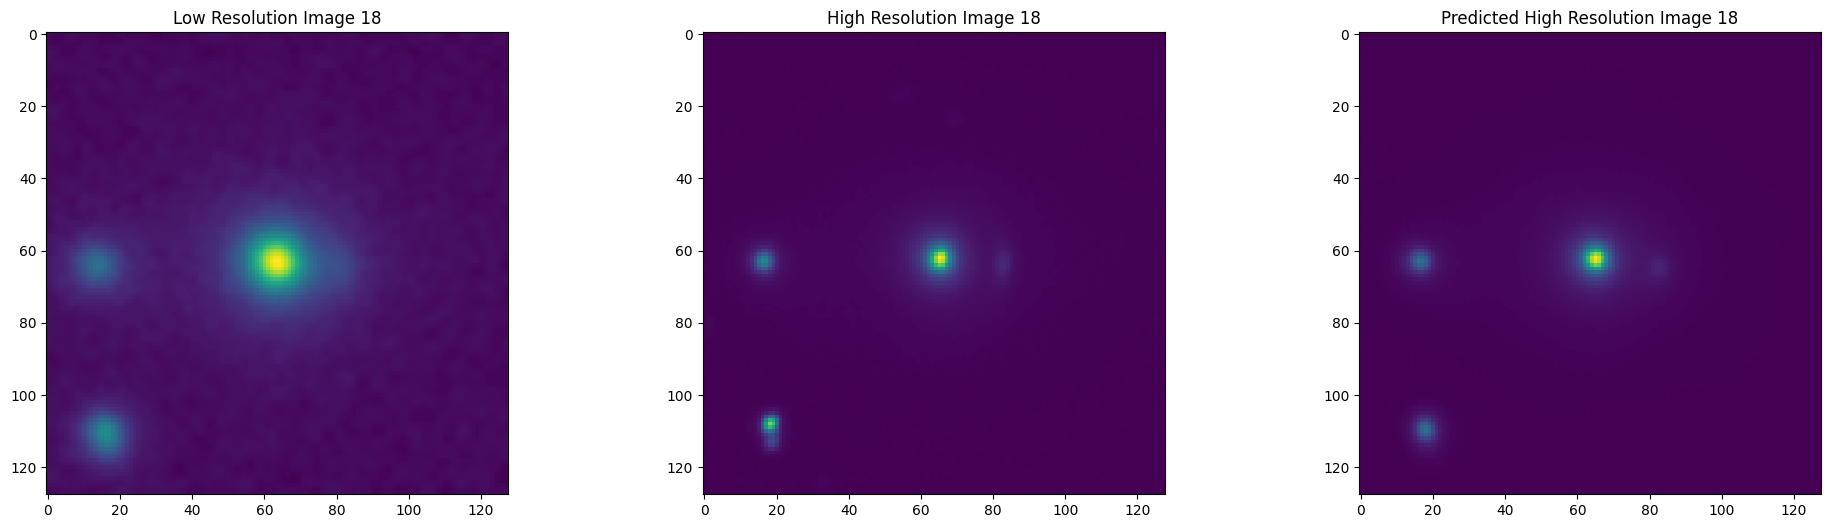

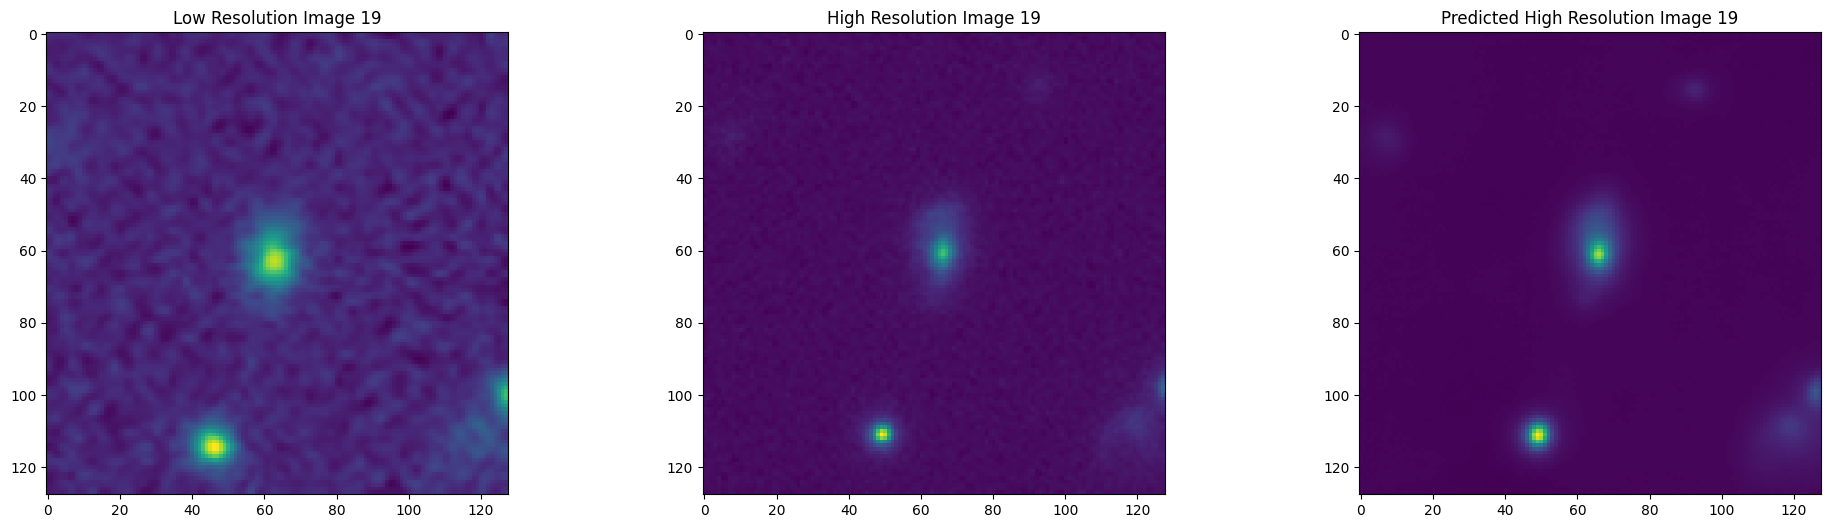

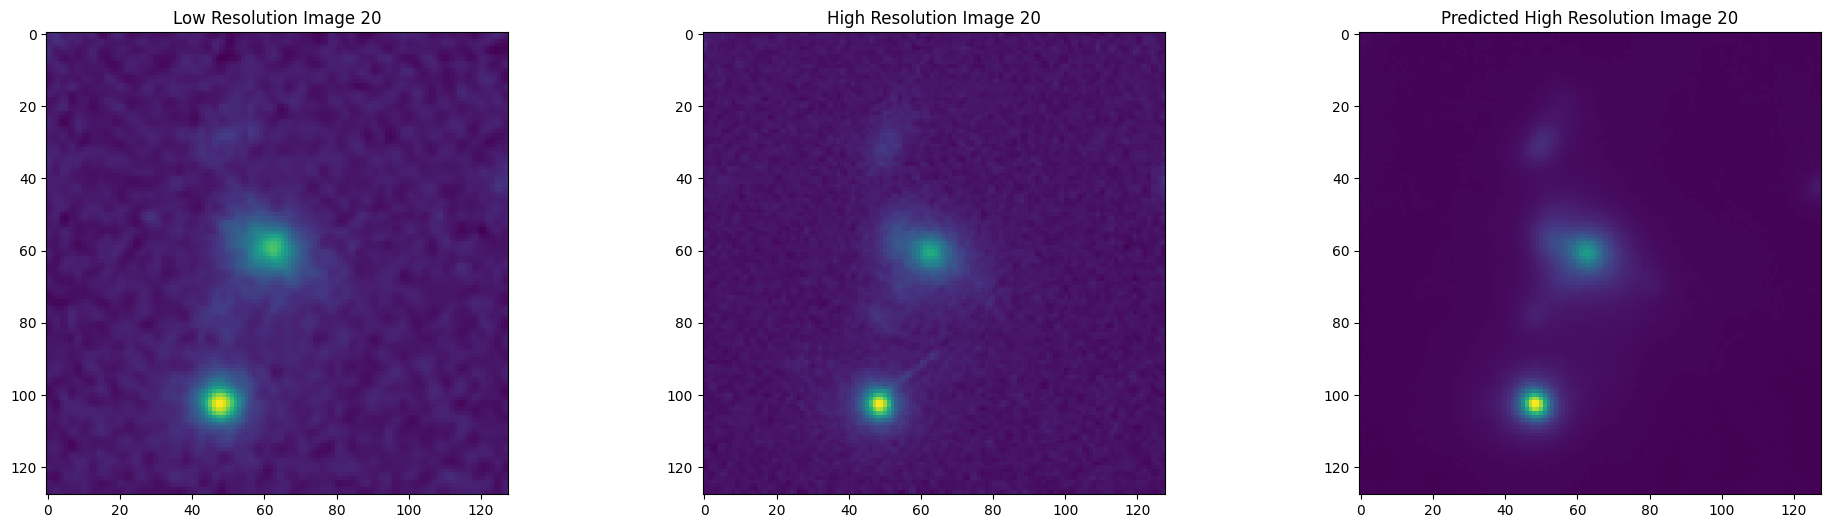

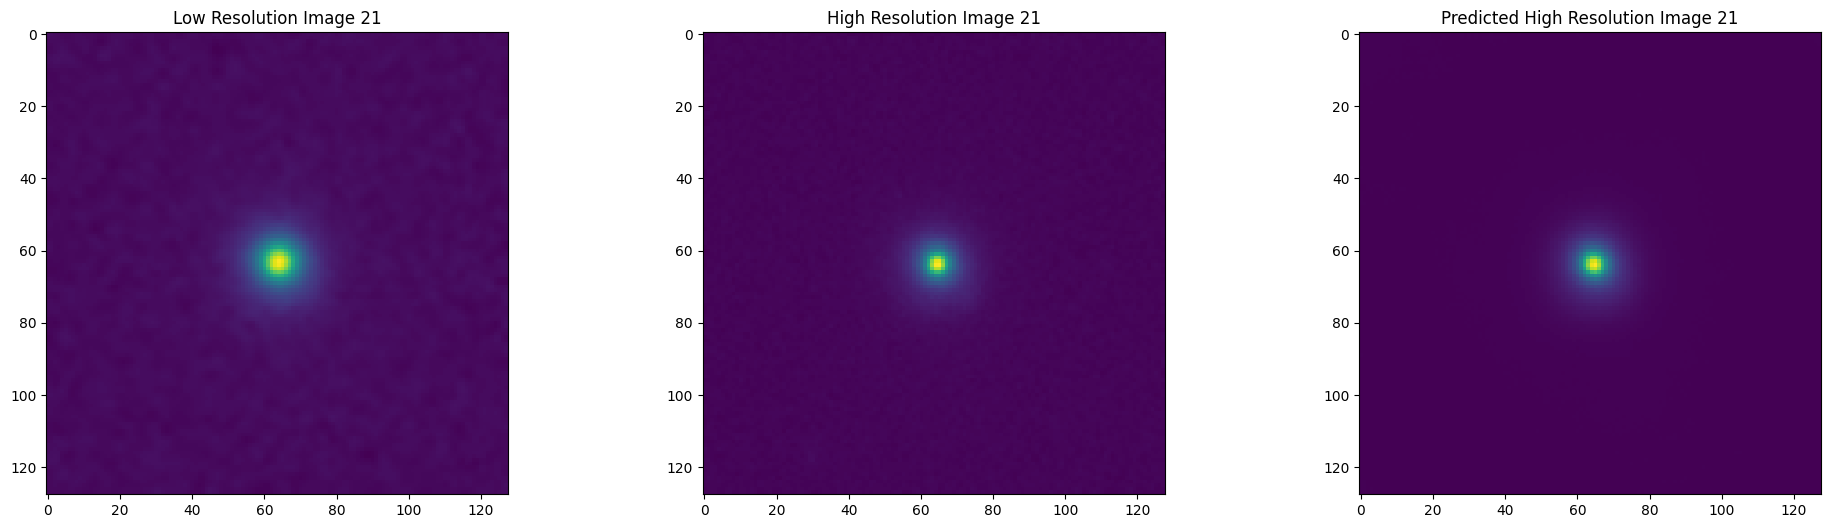

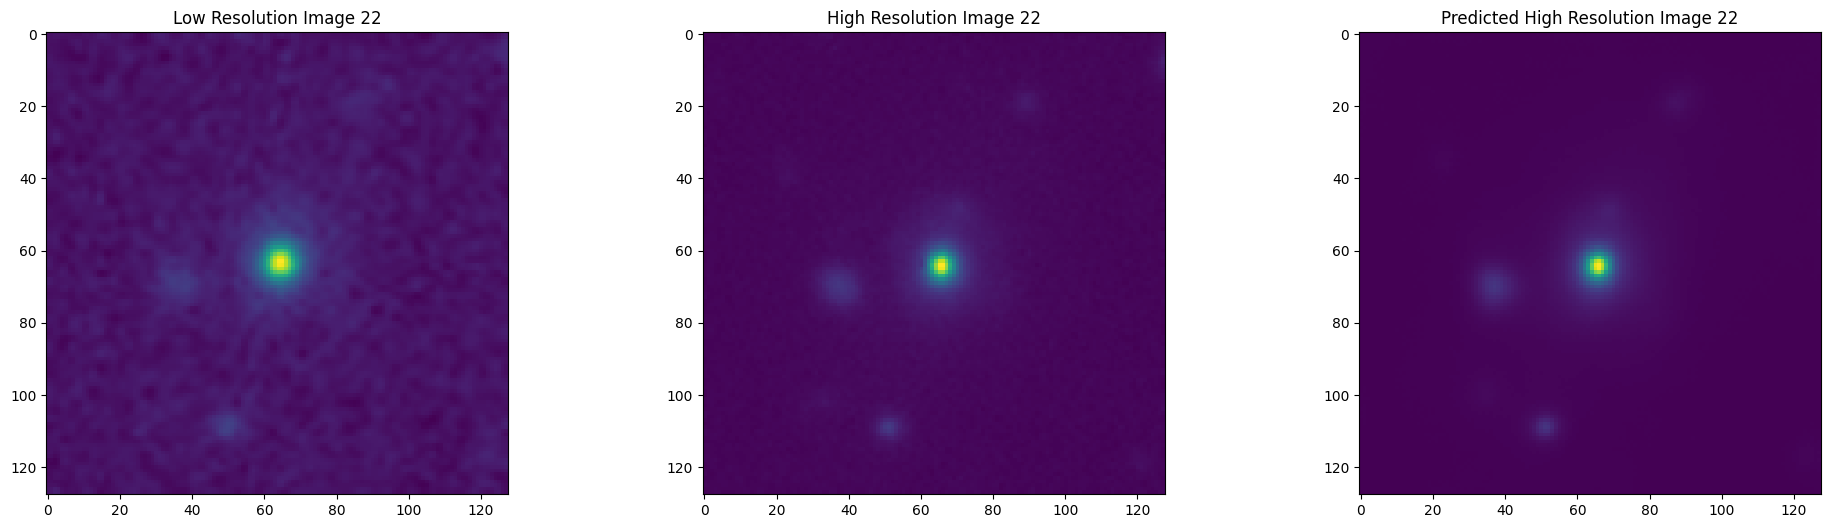

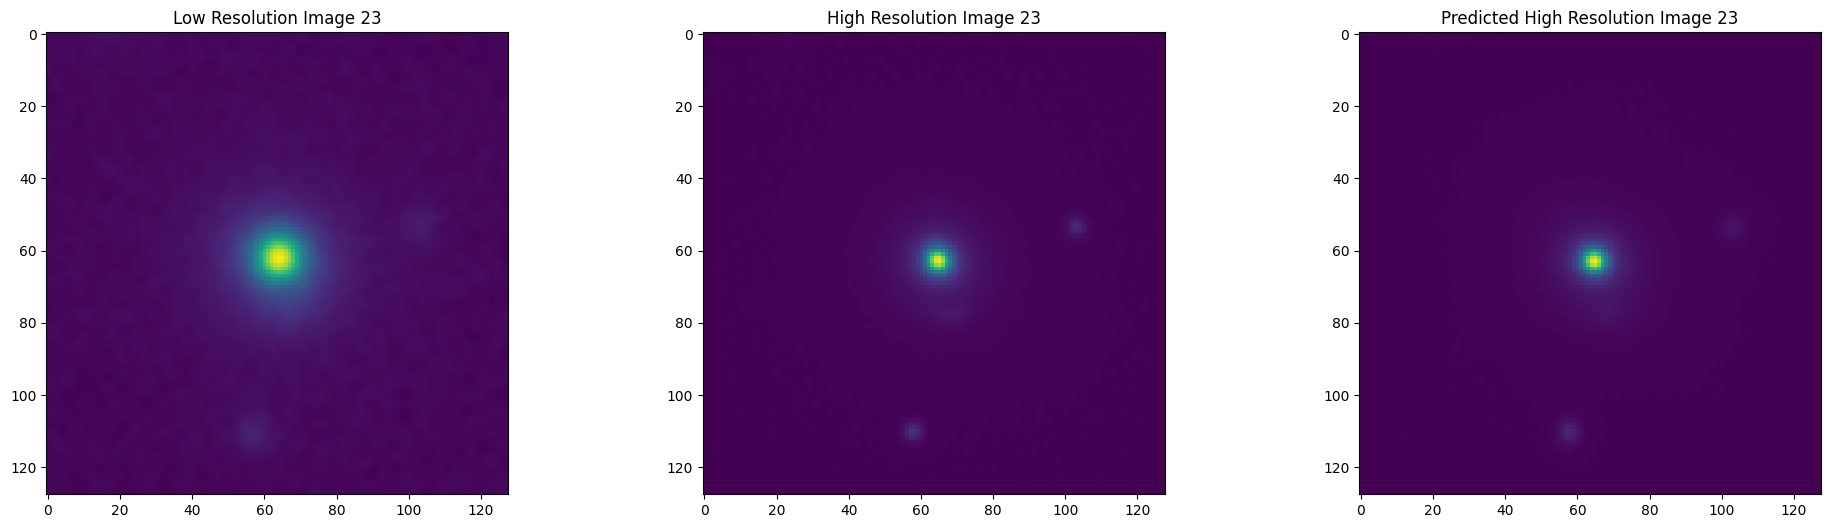

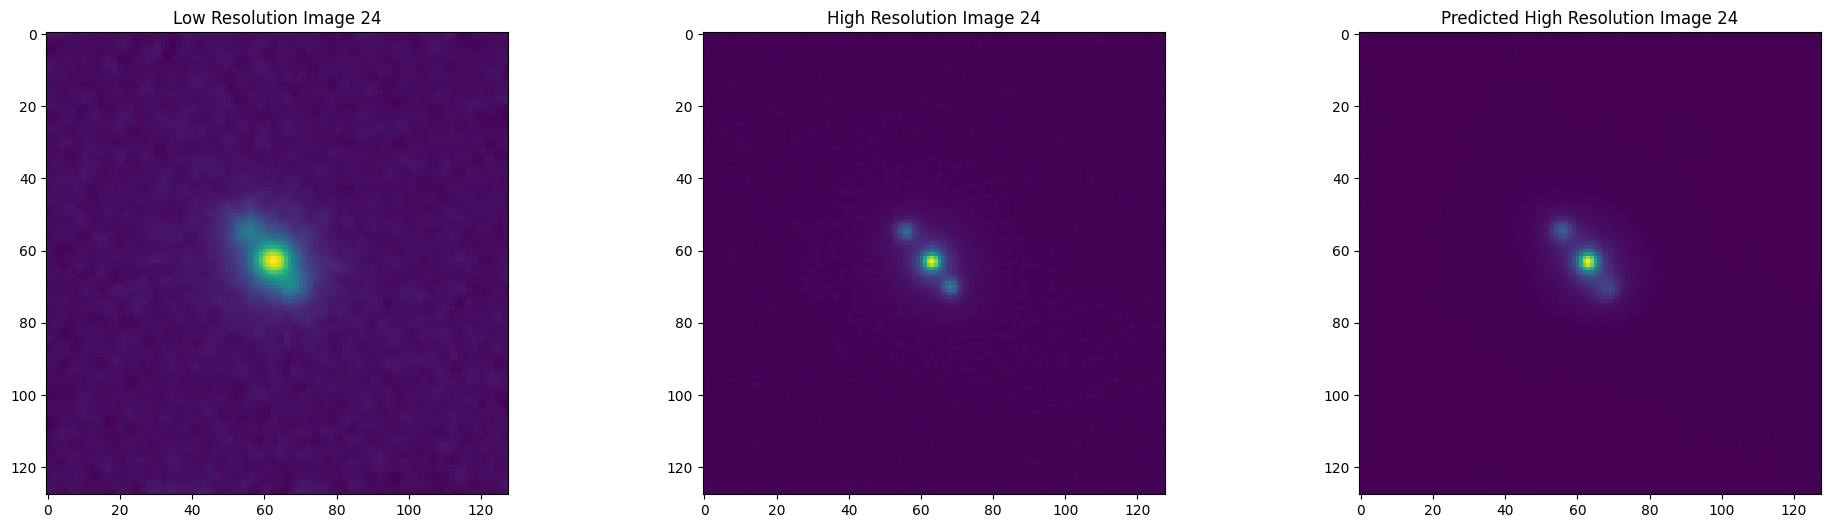

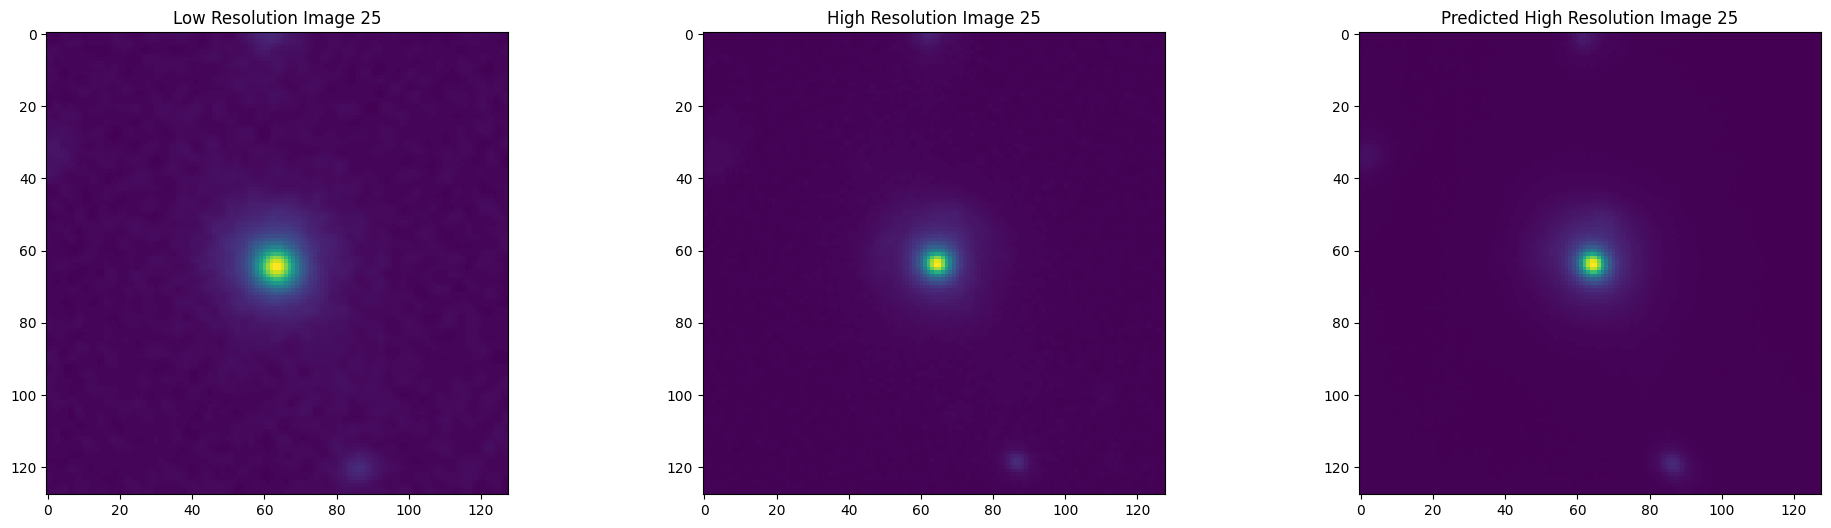

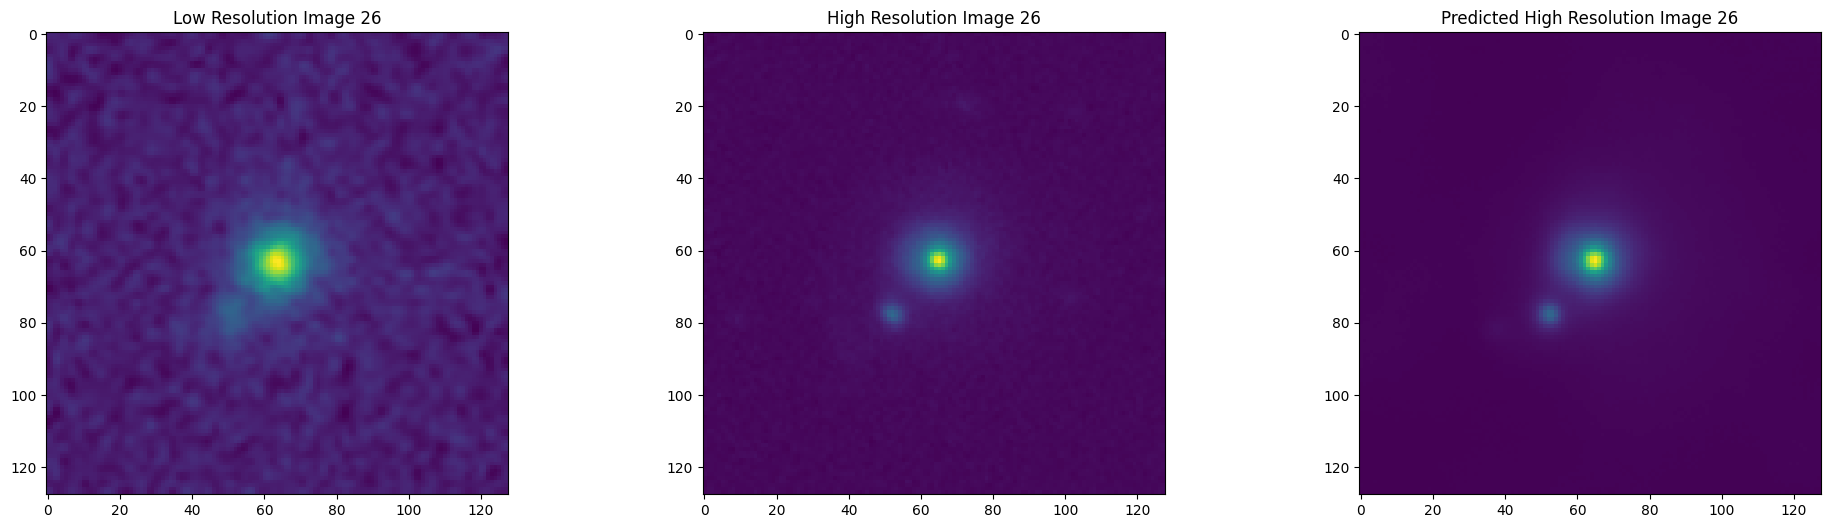

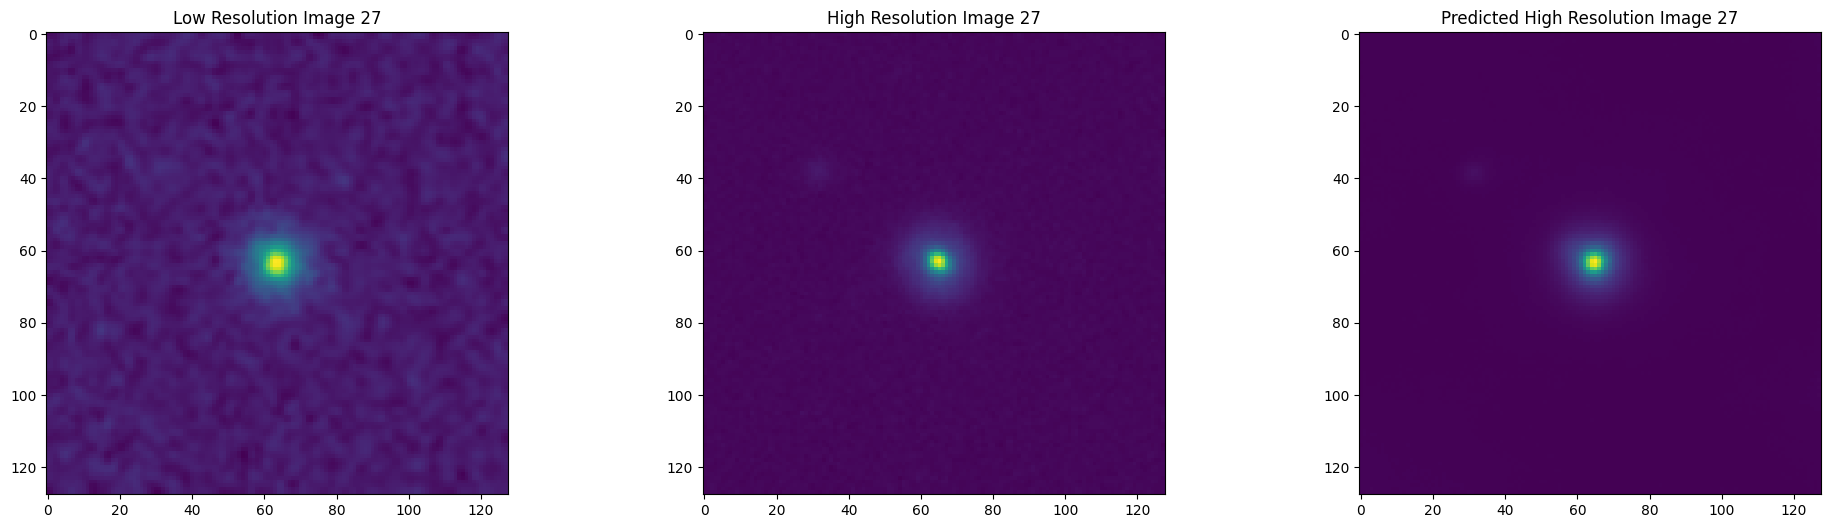

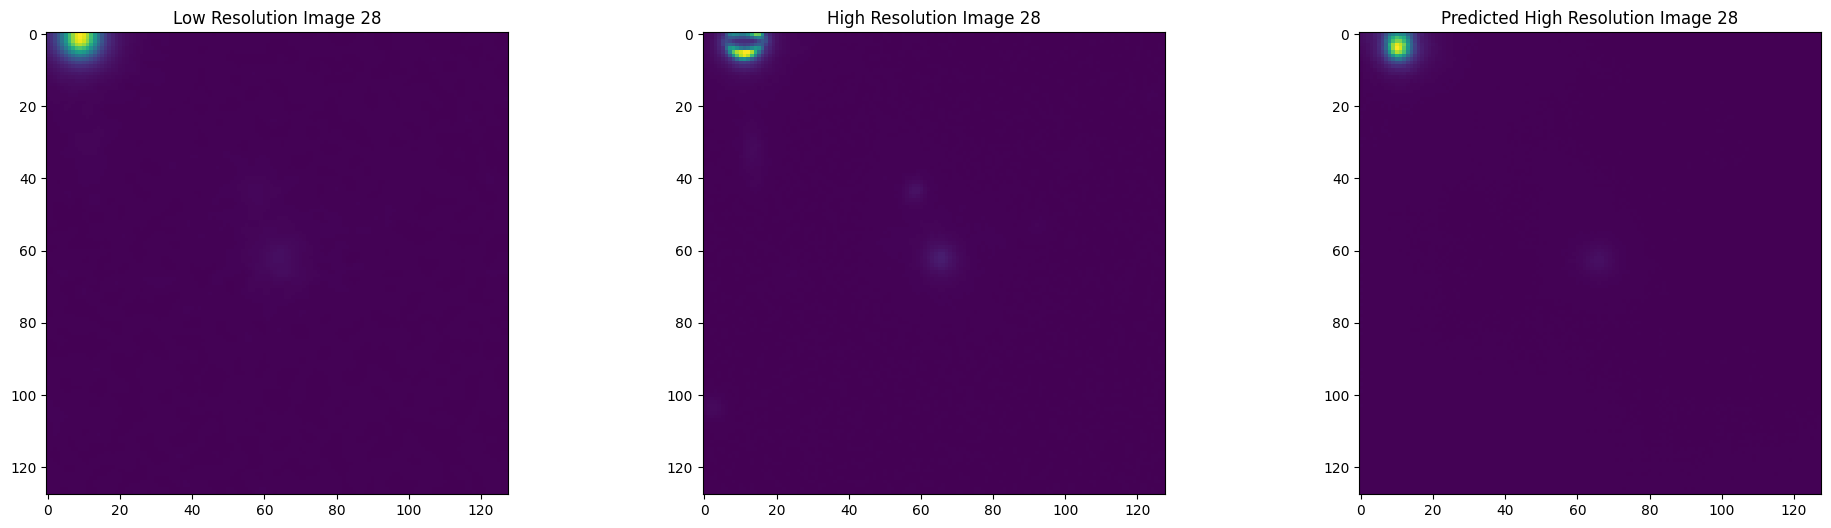

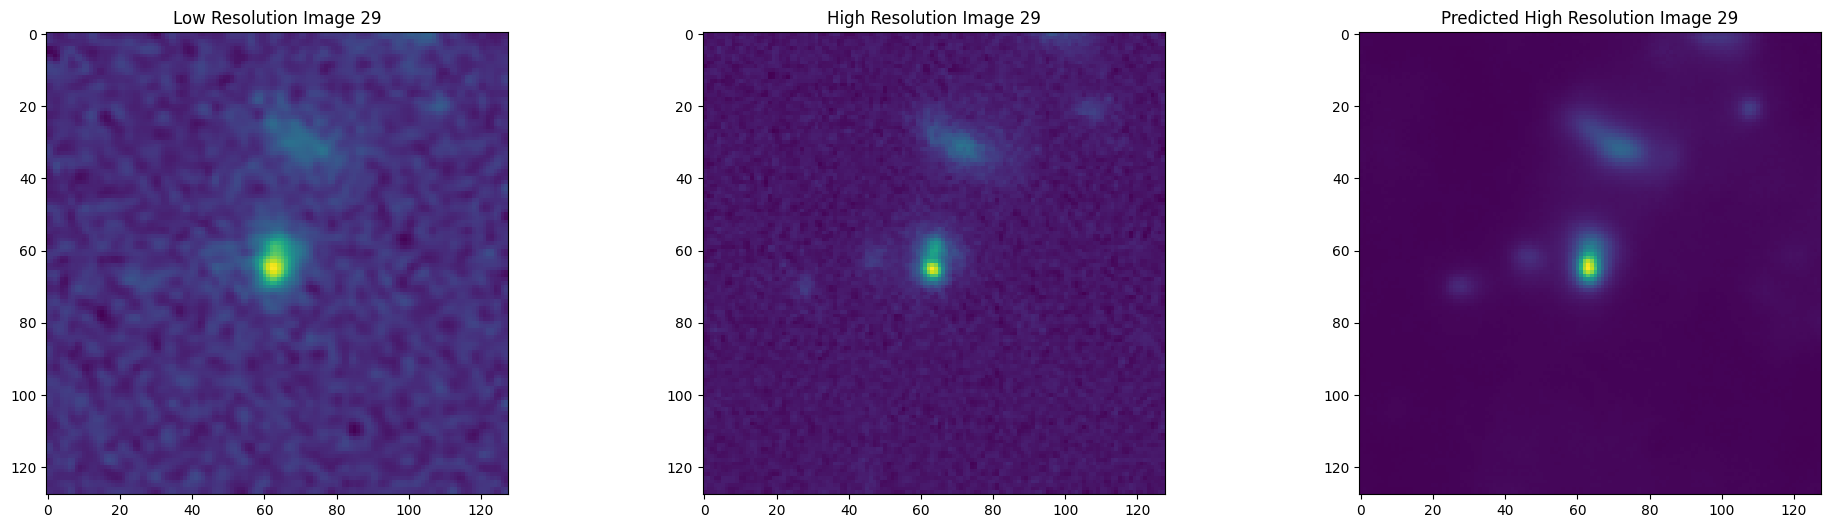

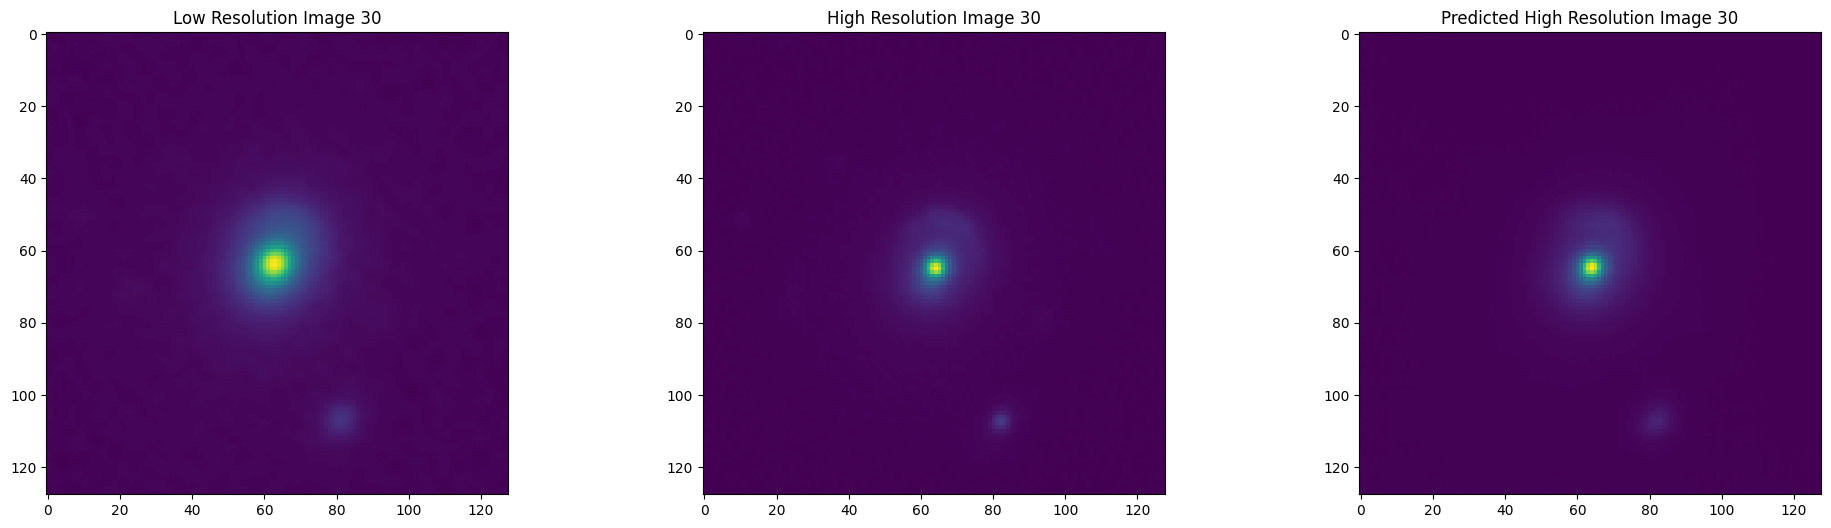

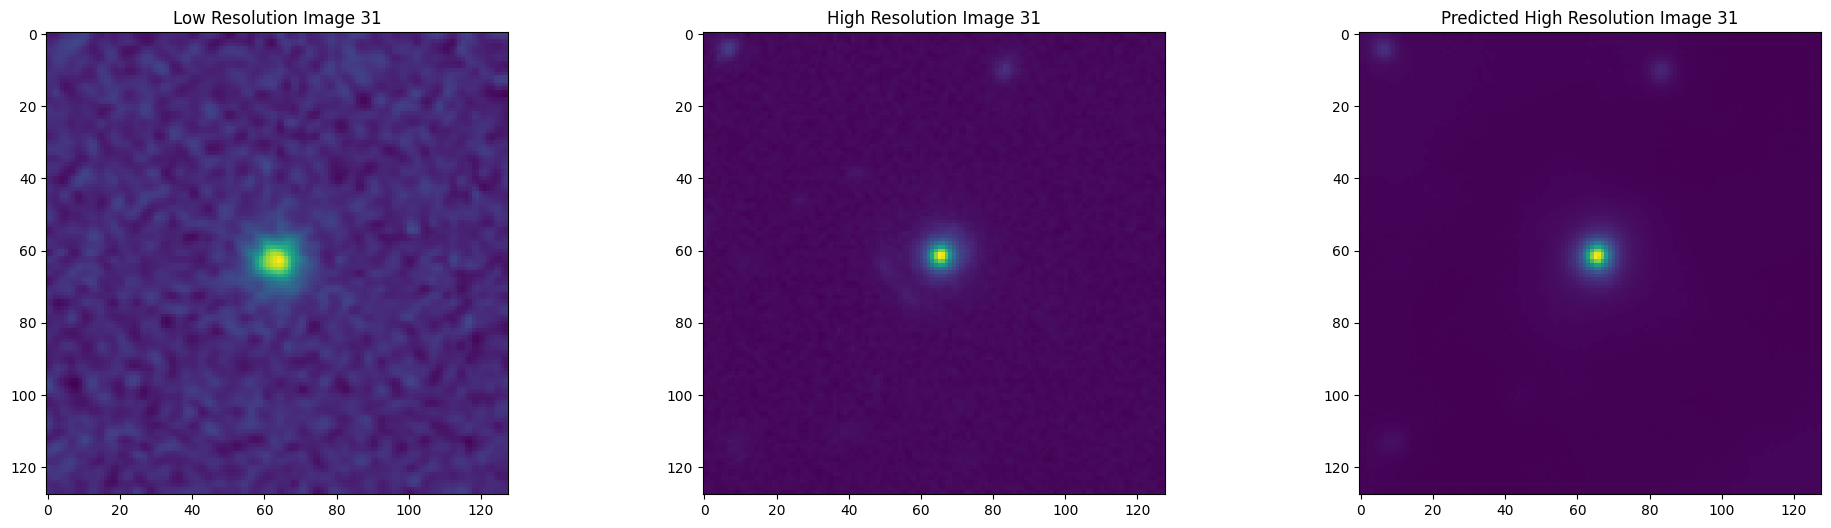

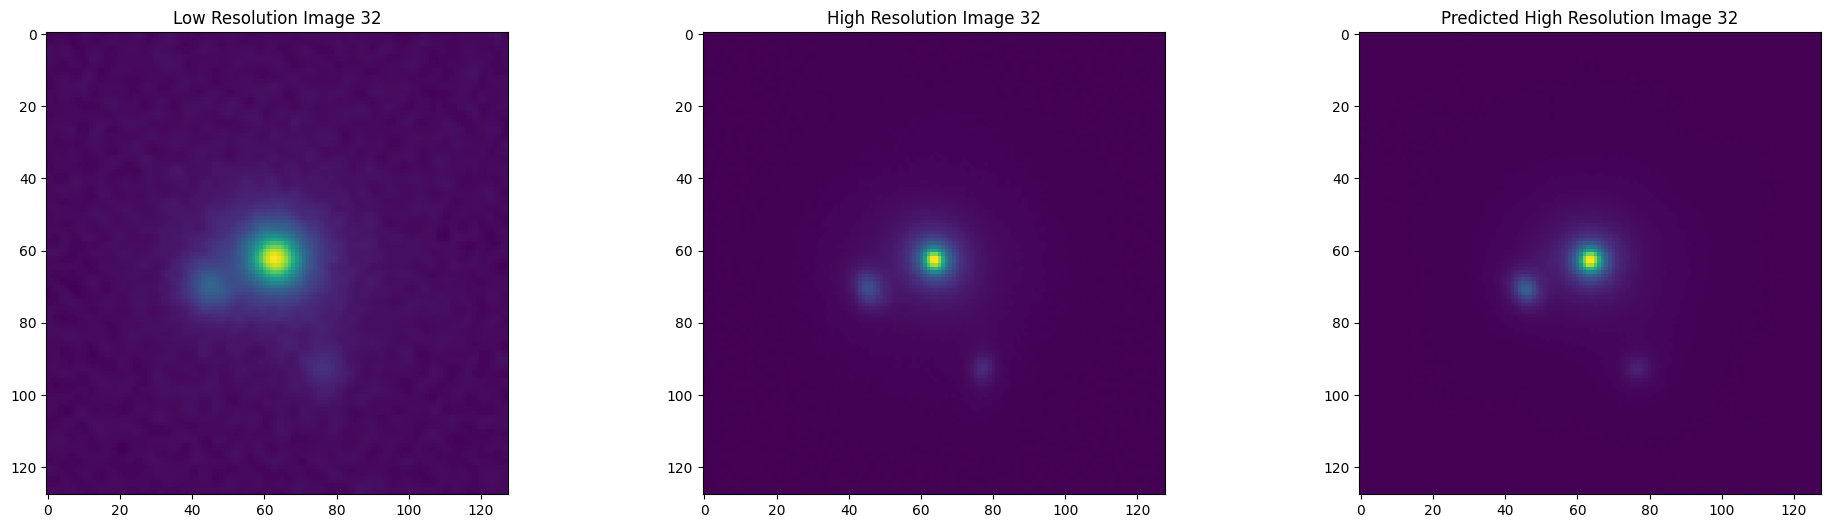

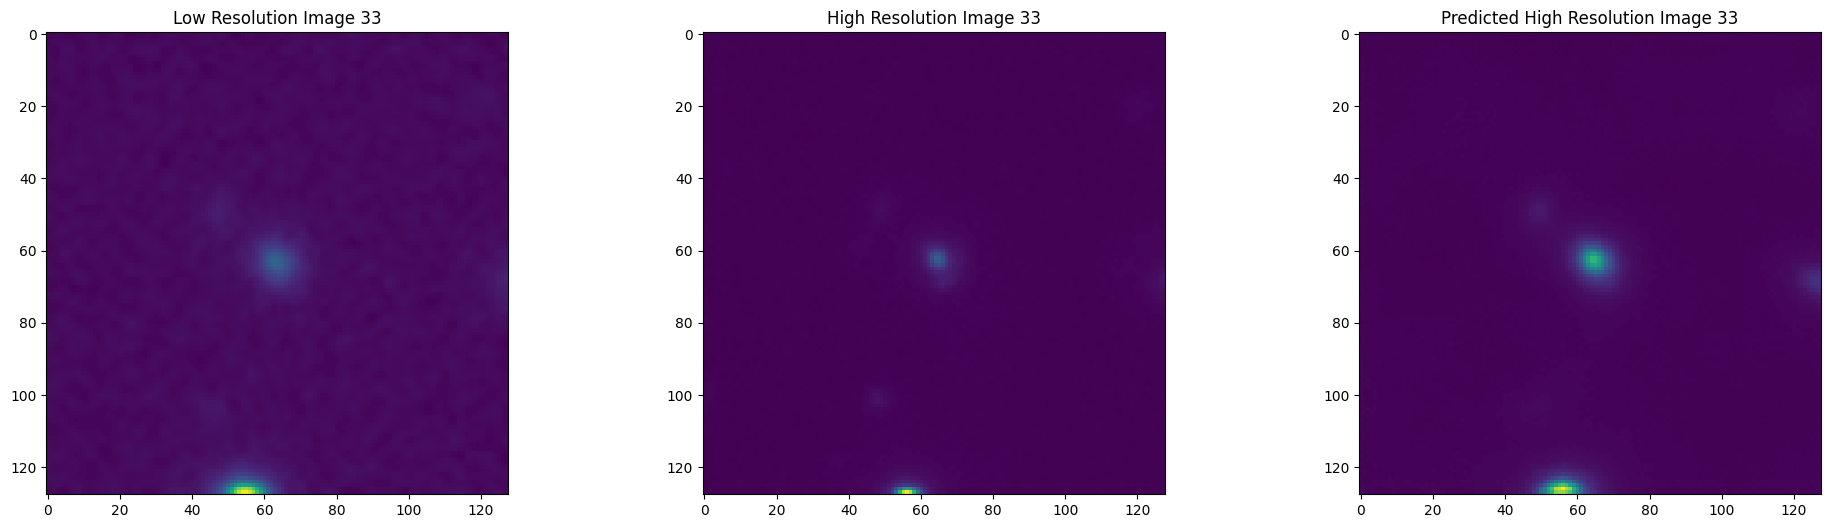

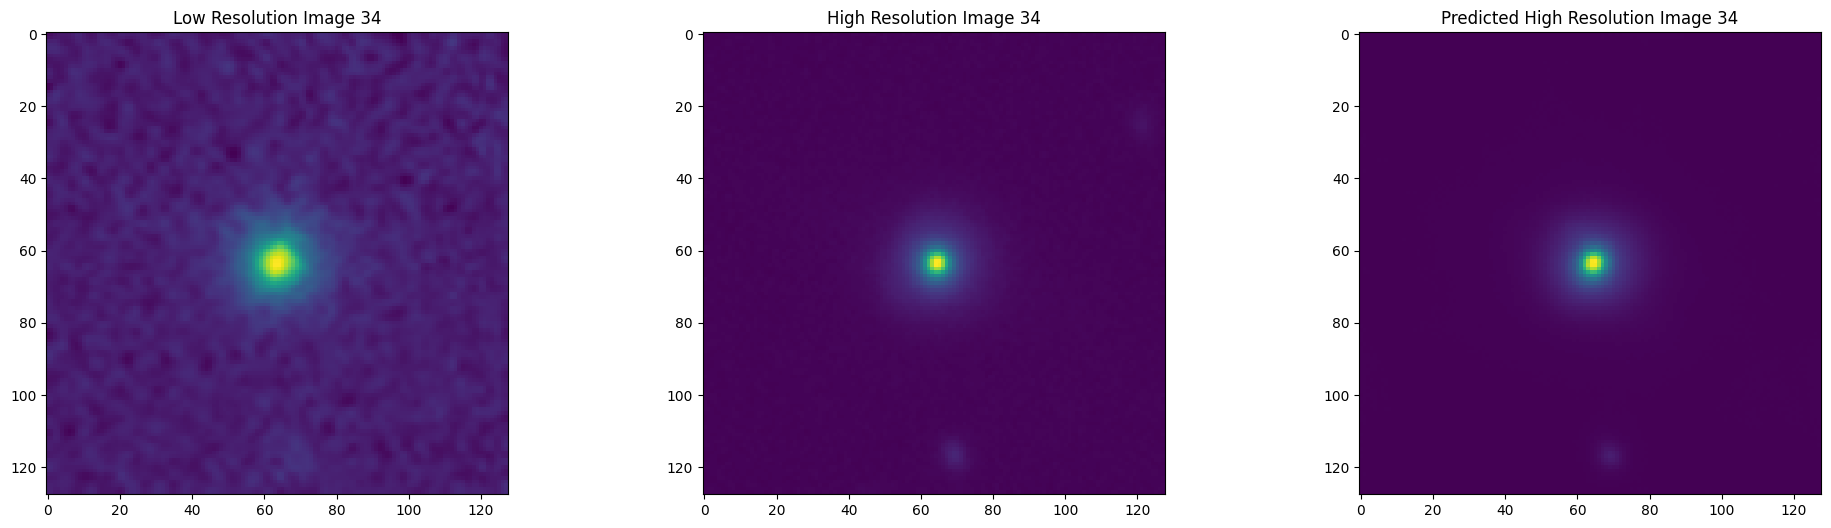

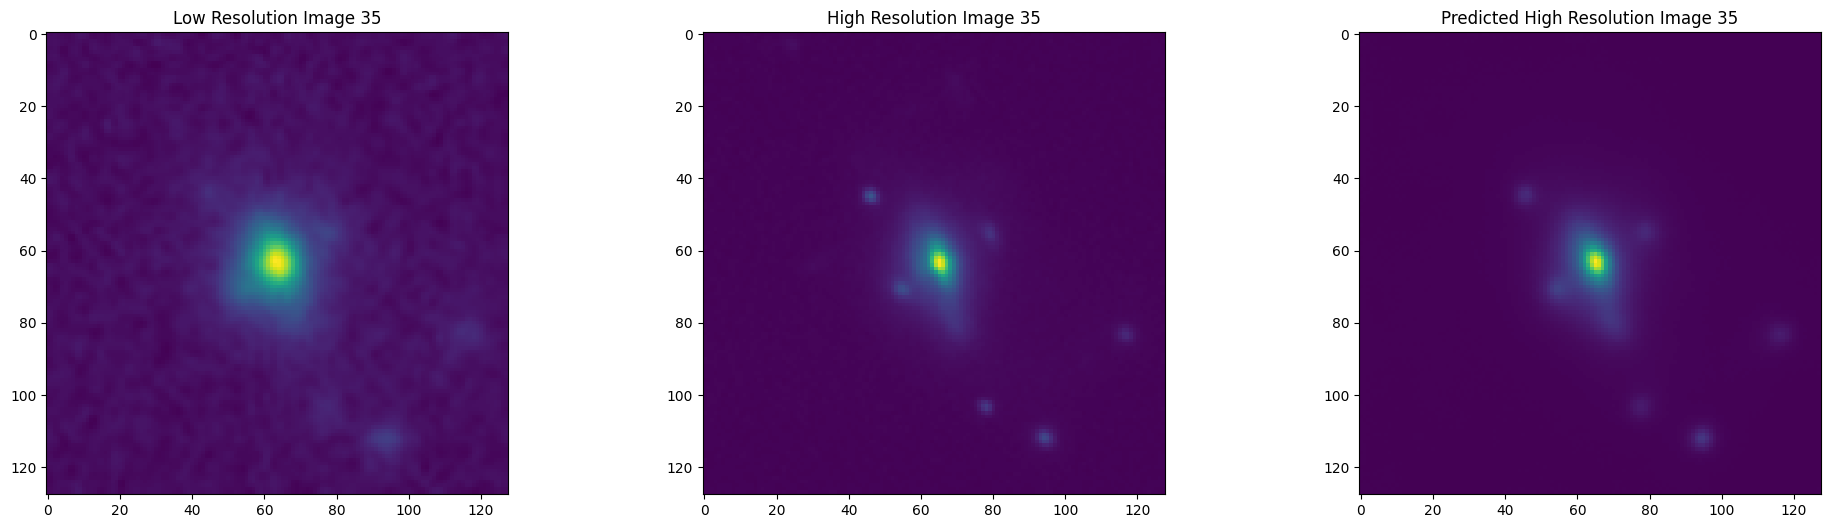

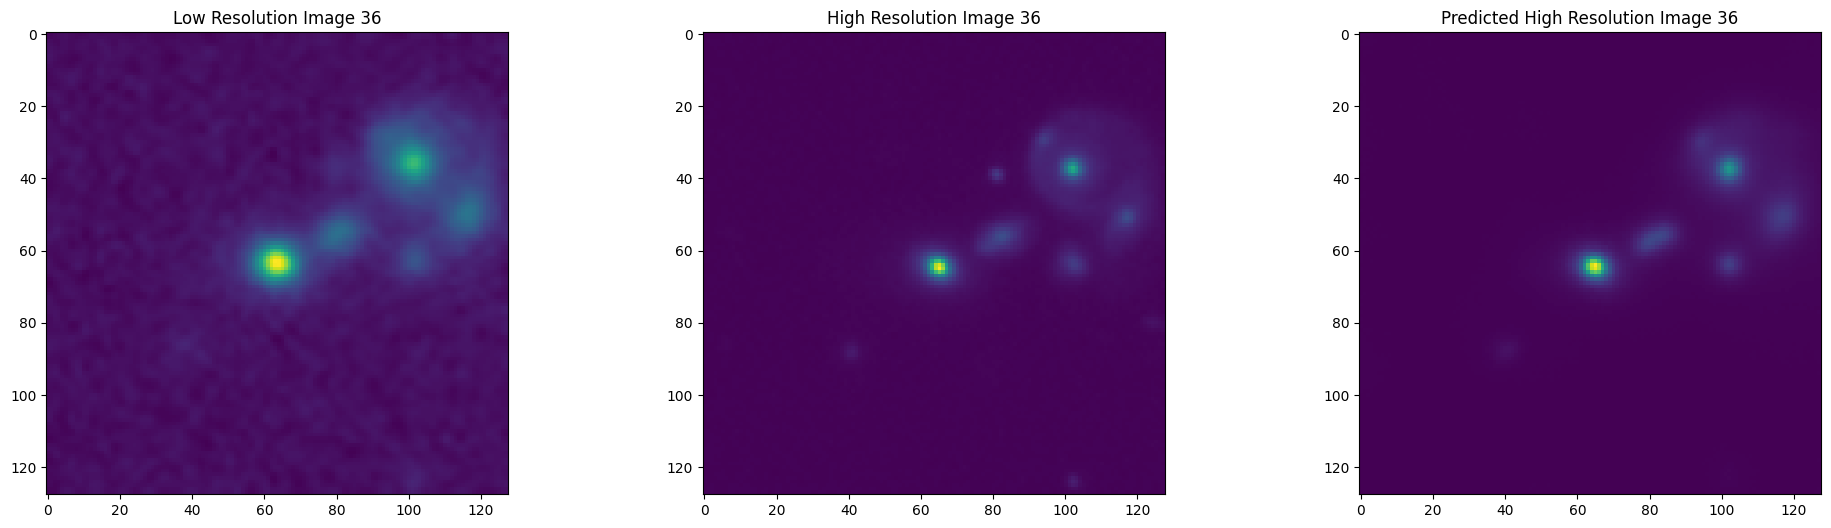

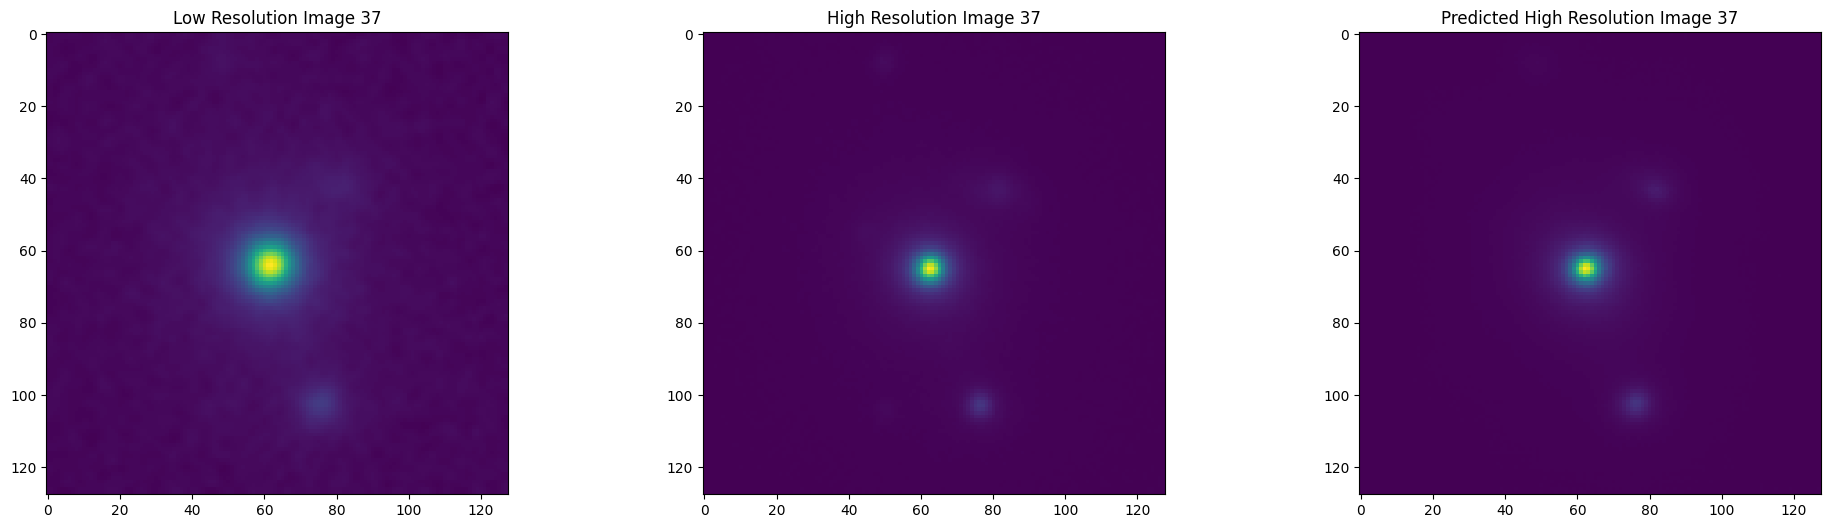

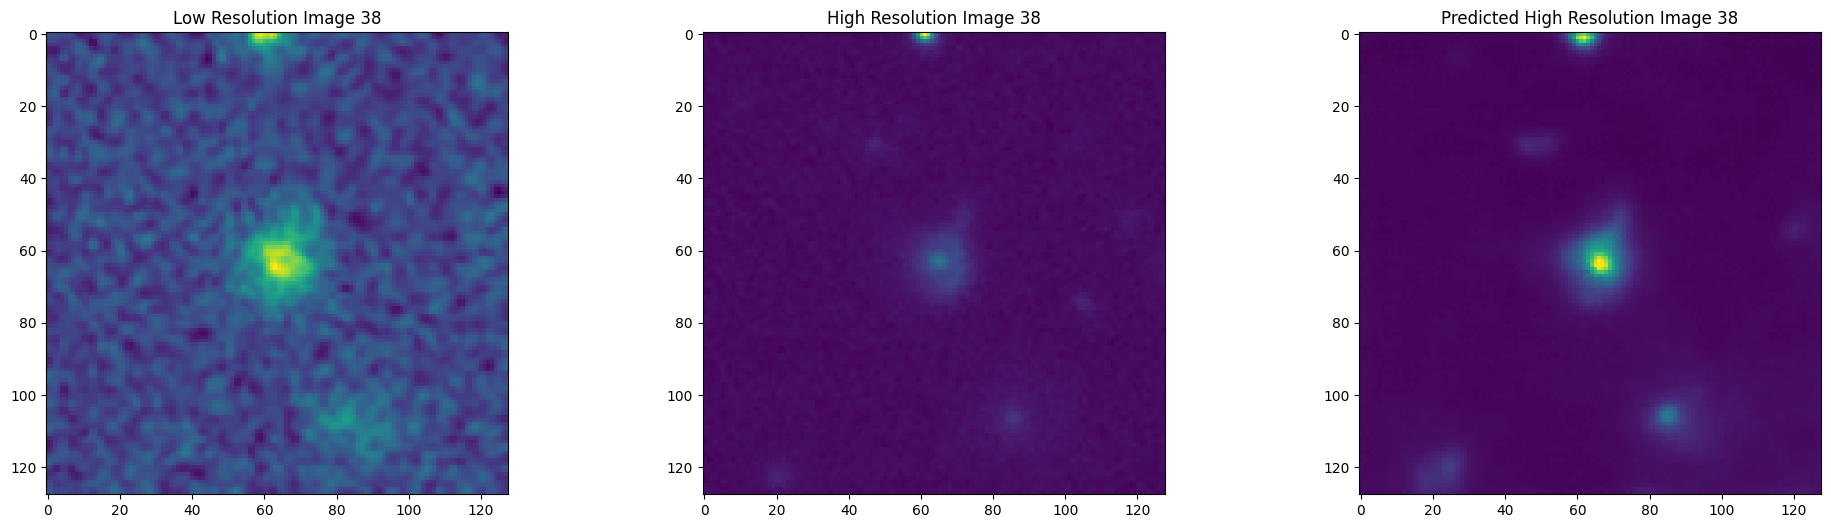

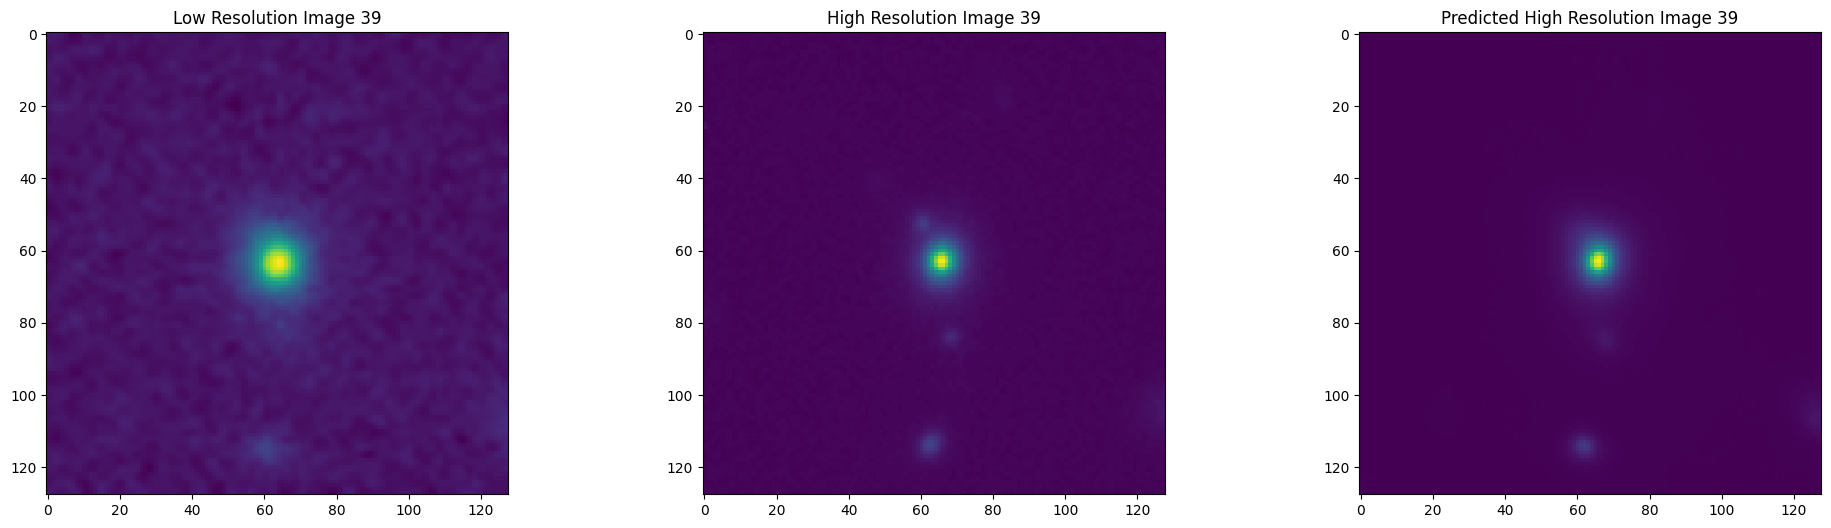

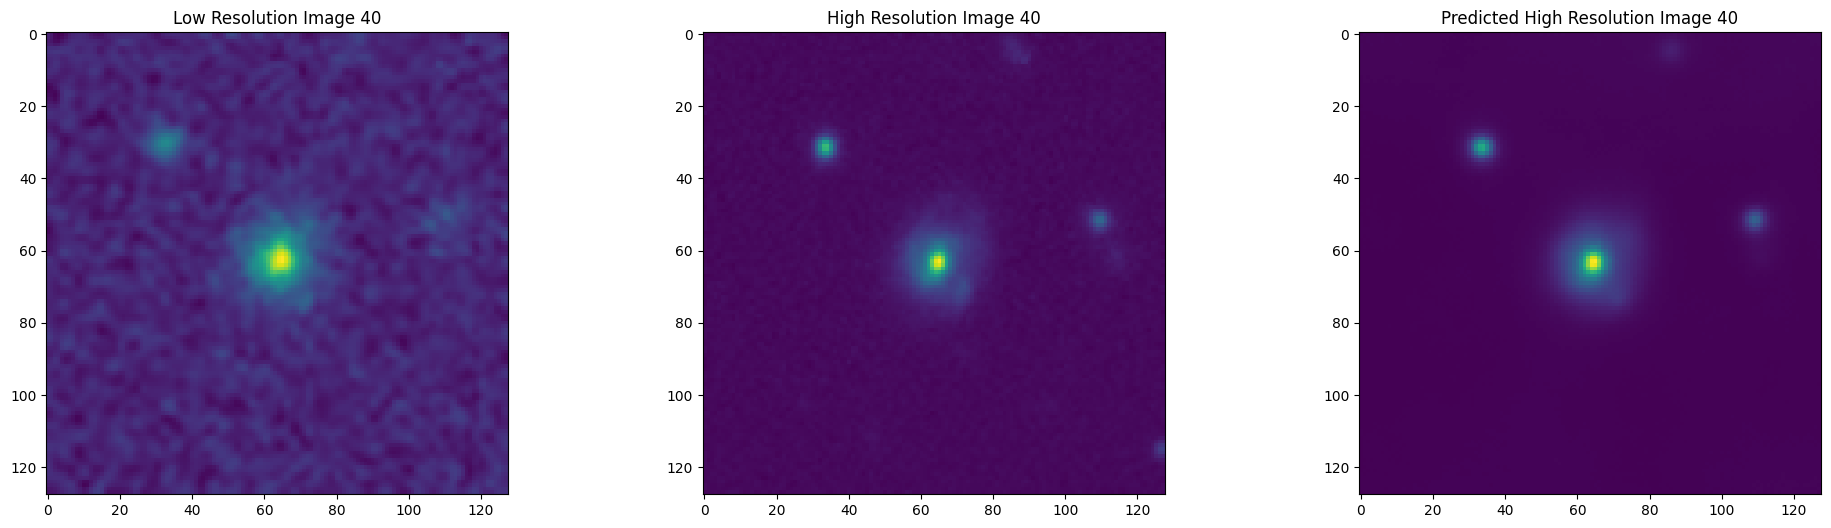

In [41]:
import matplotlib.pyplot as plt

model.eval()

# Helper functions
def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].to(device).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device).view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).to(device)

for i, (lr_batch, hr_batch) in enumerate(test_dataloader):
    if i >= 10:  
        break

    lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
    
    timesteps = torch.randint(0, T, (lr_batch.size(0),), device=device).long()
    with torch.no_grad():
        noisy_lr_batch, _ = forward_diffusion_sample(lr_batch, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
        pred_hr_batch = model(noisy_lr_batch, lr_batch, timesteps)
    
    lr_batch = lr_batch.cpu().detach()
    hr_batch = hr_batch.cpu().detach()
    noisy_lr_batch = noisy_lr_batch.cpu().detach()
    pred_hr_batch = pred_hr_batch.cpu().detach()
    
    for j in range(lr_batch.size(0)):  # Iterate through each image in the batch
        lr = lr_batch[j].squeeze()
        hr = hr_batch[j].squeeze()
        noisy_lr = noisy_lr_batch[j].squeeze()
        pred_hr = pred_hr_batch[j].squeeze()
        
        plt.figure(figsize=(24, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(lr, cmap='viridis')
        plt.title(f'Low Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 2)
        plt.imshow(hr, cmap='viridis')
        plt.title(f'High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_hr, cmap='viridis')
        plt.title(f'Predicted High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.show()